# Preparação e tratamento dos dados - Parte 2

## Objetivo

Este código tem como objetivo tratar a base "ans.csv" desenvolvida na parte 1

As etapas abordadas no tratamento de dados desenvolvido neste código são as seguintes:

1. Filtragem por tipo de contratação, porte e modalidade de operadora
1. Agrupamento das informações de receita, despesa e total de beneficiarios
1. Identificação e tratamento de dados outliers de receita e despesa
1. Criação da base para ser utilizada na etapa de forecast

## Este código aborda as informações do seguinte segmento:

### Adesão - Modalidade Cooperativa Médica

In [3]:
#Bibliotecas utilizadas no código
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.core.reshape.merge import merge
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.5f}'.format

In [4]:
#Funções auxiliares

def sum_billion(x):    
    return round(((x.sum())/1000000000.0),2)

def sum_million(x):    
    return round(((x.sum())/1000000.0),2)

def sum_thousand(x):    
    return round(((x.sum())/1000.0),2)

def media_agregada(x):    
    return round(((x.sum())/12.0),0)

### Seleção do Período para o tratamento dos dados

In [5]:
#Seleção do Periodo de análise

inicio = '2017-09-01'

fim = '2022-03-01'

Periodo = [inicio, fim]

### Parametros para filtragem dos dados

In [6]:
#Parametros para filtragem dos dados

contratacao_list = ['Adesao', 'Empresarial', 'Individual']

modalidade_list = ['Medicina de Grupo', 'Cooperativa Médica', 'Autogestão', 'Filantropia', 'Seguradora']

tipo_contratacao = 'Adesao'

tipo_modalidade = 'Cooperativa Médica'

## Leitura dos dados

Carregamento e leitura da base desenvolvida na parte 1 do código

In [7]:
path = f'D:/TCC/tcc-main/codigos/preparacao_dados/analise_agrupadas' + '\\' + 'ans.csv'

ans = pd.read_csv(path, sep=';', decimal= ',', encoding='mbcs')  #Leitura da base

#modificando os tipos de dados

ans['ano'] = ans['ano'].astype('str')

ans['cd_ops'] = ans['cd_ops'].astype('str')

ans['lg_cancelada'] = ans['lg_cancelada'].astype('str')

ans['lg_nova_ops'] = ans['lg_nova_ops'].astype('str')

ans['ano'] = pd.PeriodIndex(ans['ano'], freq="Y")

ans['trimestre'] = pd.PeriodIndex(ans['trimestre'], freq="Q")

#Filtrando os dados até 2021
ans = ans[(ans.ano < '2022')]

ans = ans.replace(' NaN', np.NaN)

ans = ans.dropna()

#Filtra somente as operadas com flag ativas
ans_filt = ans[(ans['lg_cancelada']!='1.0') & (ans['benef']!=np.nan)].reset_index(drop=True)

ans_filt.head()


,ano,cd_ops,razao_social,modalidade,port_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,receita,despesa,benef,lg_cancelada,lg_nova_ops
0,2017,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/09/2017,2017Q3,2095967.19000,0.00000,747.00000,0.0,0.0
1,2017,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/12/2017,2017Q4,785491.93000,0.00000,719.00000,0.0,0.0
2,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/03/2018,2018Q1,791860.20000,0.00000,722.00000,0.0,0.0
3,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/06/2018,2018Q2,769499.34000,0.00000,731.00000,0.0,0.0
4,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/09/2018,2018Q3,846654.02000,0.00000,774.00000,0.0,0.0


In [8]:
#Filtra o segmento abordado neste código
ans_filt_cont_mod = ans_filt[ (ans_filt['contratacao'] == tipo_contratacao) & 
                              (ans_filt['modalidade'] == tipo_modalidade)].reset_index(drop=True)

ans_filt_cont_mod = ans_filt_cont_mod[['ano', 'cd_ops', 'razao_social', 'modalidade', 'port_ops', 'vigencia', 'contratacao', 'financiamento', 'trimestre', 'receita', 'despesa', 'benef']]

ans_filt_cont_mod.head()


,ano,cd_ops,razao_social,modalidade,port_ops,vigencia,contratacao,financiamento,trimestre,receita,despesa,benef
0,2019,300136,UNIMED LITORAL SUL/RS - COOPERATIVA MÉDICA LTDA.,Cooperativa Médica,Médio,P,Adesao,Pre-estabelecido,2019Q1,497251.97000,276607.16000,553.00000
1,2019,300136,UNIMED LITORAL SUL/RS - COOPERATIVA MÉDICA LTDA.,Cooperativa Médica,Médio,P,Adesao,Pre-estabelecido,2019Q2,735076.44000,550612.96000,559.00000
2,2019,300136,UNIMED LITORAL SUL/RS - COOPERATIVA MÉDICA LTDA.,Cooperativa Médica,Médio,P,Adesao,Pre-estabelecido,2019Q3,733381.57000,691165.86000,552.00000
3,2019,300136,UNIMED LITORAL SUL/RS - COOPERATIVA MÉDICA LTDA.,Cooperativa Médica,Médio,P,Adesao,Pre-estabelecido,2019Q4,761232.71000,765260.32000,915.00000
4,2020,300136,UNIMED LITORAL SUL/RS - COOPERATIVA MÉDICA LTDA.,Cooperativa Médica,Médio,P,Adesao,Pre-estabelecido,2020Q1,865752.71000,855869.21000,1015.00000


In [9]:
ans_filt_cont_mod[['ano','cd_ops','trimestre','receita','despesa','benef','modalidade','port_ops','contratacao']].to_csv('ade_coopmed.csv', sep=';', index=False, encoding='mbcs', decimal=',')

ans_filt_cont_mod.groupby(['ano','cd_ops','razao_social','trimestre']).agg({'receita':lambda x: sum_million(x),'despesa':lambda x: sum_million(x)}).head()

receita  despesa
ano  cd_ops razao_social                                       trimestre                  
2017 300713 UNIMED DE ASSIS COOPERATIVA DE TRABALHO MÉDICO     2017Q3     5.51000  4.03000
                                                               2017Q4     2.11000  1.43000
     301060 UNIMED ITUIUTABA COOPERATIVA TRABALHO MÉDICO LTDA. 2017Q3     3.22000  2.39000
                                                               2017Q4     1.14000  0.47000
     301124 UNIMED GURUPI COOPERATIVA DE TRABALHO MÉDICO       2017Q3     4.25000  3.17000

### Agregação dos valores de receita e despesa e quantidade de beneficiarios

In [10]:
ans_filt_cont_mod_agrup = ans_filt_cont_mod.groupby(['ano','trimestre'], as_index=False).agg({ 'receita':lambda x: sum_billion(x),
                                                                                               'despesa':lambda x: sum_billion(x),
                                                                                               'benef': 'sum',
                                                                                               'cd_ops':lambda x: x.nunique()})

ans_filt_cont_mod_agrup['ind_sinistralidade'] = ans_filt_cont_mod_agrup.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_filt_cont_mod_agrup.columns = ['ano','trimestre','receita','despesa','benef','n_ops','ind_sinistralidade']

ans_filt_cont_mod_agrup = ans_filt_cont_mod_agrup[['trimestre','receita','despesa','benef','n_ops','ind_sinistralidade']]

ans_filt_cont_mod_agrup = ans_filt_cont_mod_agrup[(ans_filt_cont_mod_agrup.trimestre > '2017Q3') & (ans_filt_cont_mod_agrup.trimestre < '2022Q1')]

ans_filt_cont_mod_agrup[['n_ops','benef']] = ans_filt_cont_mod_agrup[['n_ops','benef']].astype('int')

ans_filt_cont_mod_agrup.set_index('trimestre', inplace=True)

ans_filt_cont_mod_agrup

,receita,despesa,benef,n_ops,ind_sinistralidade
trimestre,,,,,
2017Q4,2.88000,2.31000,2423132,224,80.21000
2018Q1,2.44000,1.89000,2227738,225,77.46000
2018Q2,3.30000,2.63000,2486211,229,79.70000
2018Q3,3.10000,2.49000,2502004,230,80.32000
2018Q4,3.80000,1.72000,2496940,229,45.26000
2019Q1,3.13000,2.45000,2479968,231,78.27000
2019Q2,2.86000,2.41000,2303723,233,84.27000
2019Q3,3.99000,3.07000,2593544,236,76.94000
2019Q4,3.53000,2.83000,2692893,237,80.17000


## As próximas etapas tratam da identificação de outliers e tratamentes desses dados com problemas

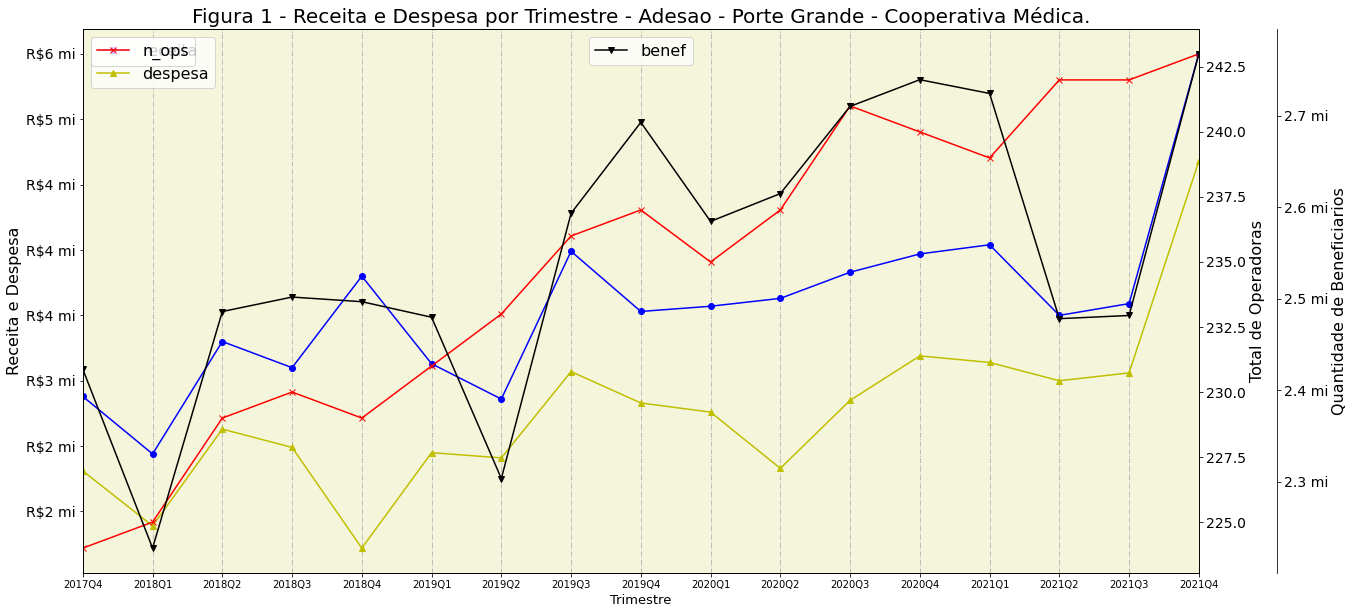

In [11]:
#Plotagem dos dados agregados
df_plot = ans_filt_cont_mod_agrup.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 1 - Receita e Despesa por Trimestre - Adesao - Porte Grande - Cooperativa Médica.',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} mi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(yticks, fontsize = 14)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

ax3 = ax1.twinx()

ax3.spines.right.set_position(("axes", 1.07))

df_plot.plot(y=['benef'], figsize=(20,10), style=['kv-'], ax=ax3)
ax3.set_xticks(df_plot.index)
ax3.set_xticklabels(df_plot.index)
ax3.set_xlabel('Trimestre', fontsize = 13)
yticks = ax3.get_yticks()
ax3.set_yticklabels(['{:.1f} mi'.format(x/1000000) for x in yticks], fontsize = 14)
ax3.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax3.legend(loc = 'upper center', fontsize = 16)

plt.show()

del df_plot

In [12]:
#Cria o ranking das operadoras com maior receita e despesa
ans_filt_cont_mod_agrup_ops = ans_filt_cont_mod.groupby(['ano','cd_ops','trimestre'], as_index=False).agg({'receita':lambda x: sum_million(x),
                                                                                                           'despesa':lambda x: sum_million(x),
                                                                                                           'benef': 'sum'}).reset_index(drop=True)

ans_filt_cont_mod_agrup_ops = ans_filt_cont_mod_agrup_ops.sort_values(['benef'],ascending = False).groupby('trimestre').head(100).reset_index(drop=True)

#ans_filt_ind_seg_agrup_ops.sort_values(by=['ano','benef'], ascending=[True,False], inplace=True)

ans_filt_cont_mod_agrup_ops.head()

,ano,cd_ops,trimestre,receita,despesa,benef
0,2021,343889,2021Q4,393.61000,329.35000,296127.00000
1,2021,343889,2021Q3,386.24000,282.55000,290258.00000
2,2021,343889,2021Q2,379.36000,258.46000,284408.00000
3,2021,393321,2021Q4,1723.18000,1446.59000,282565.00000
4,2020,393321,2020Q4,600.60000,411.84000,282374.00000


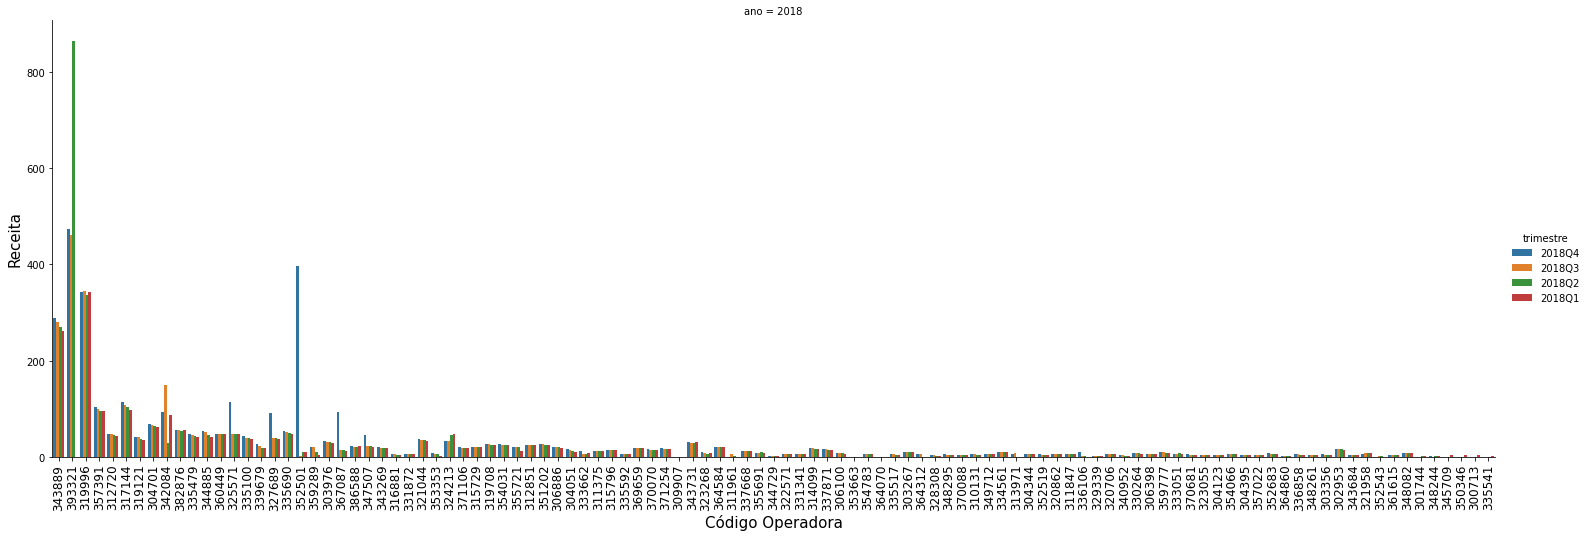

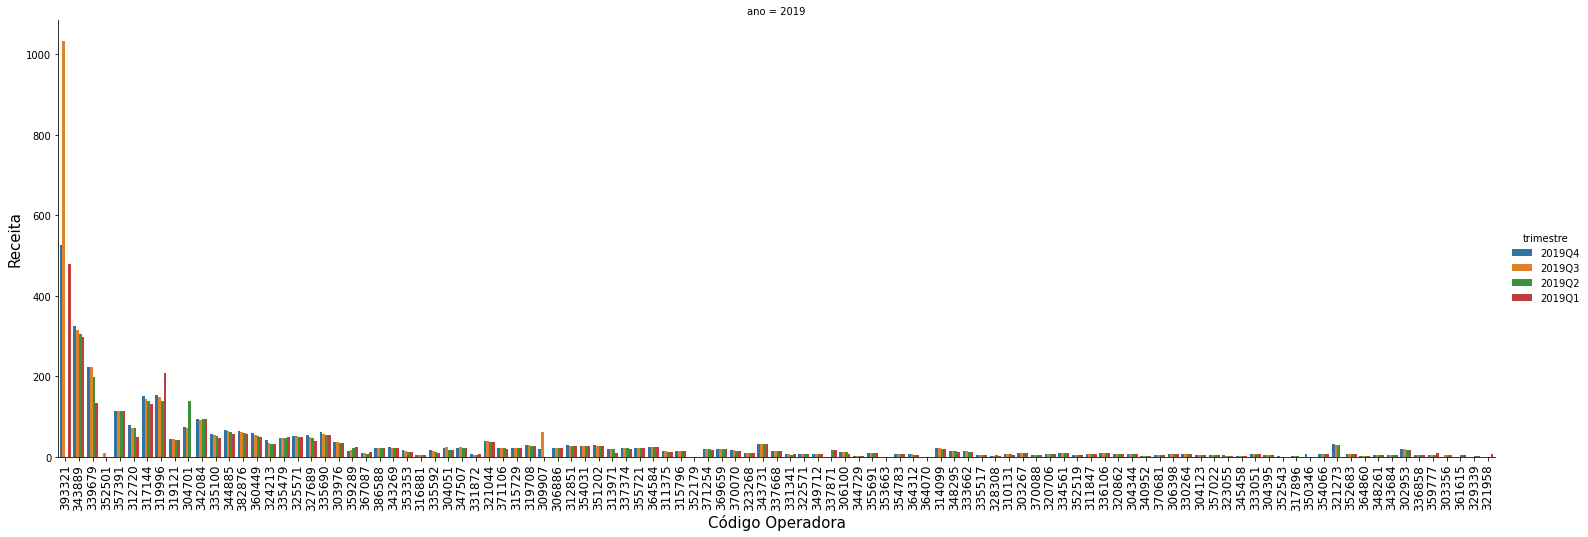

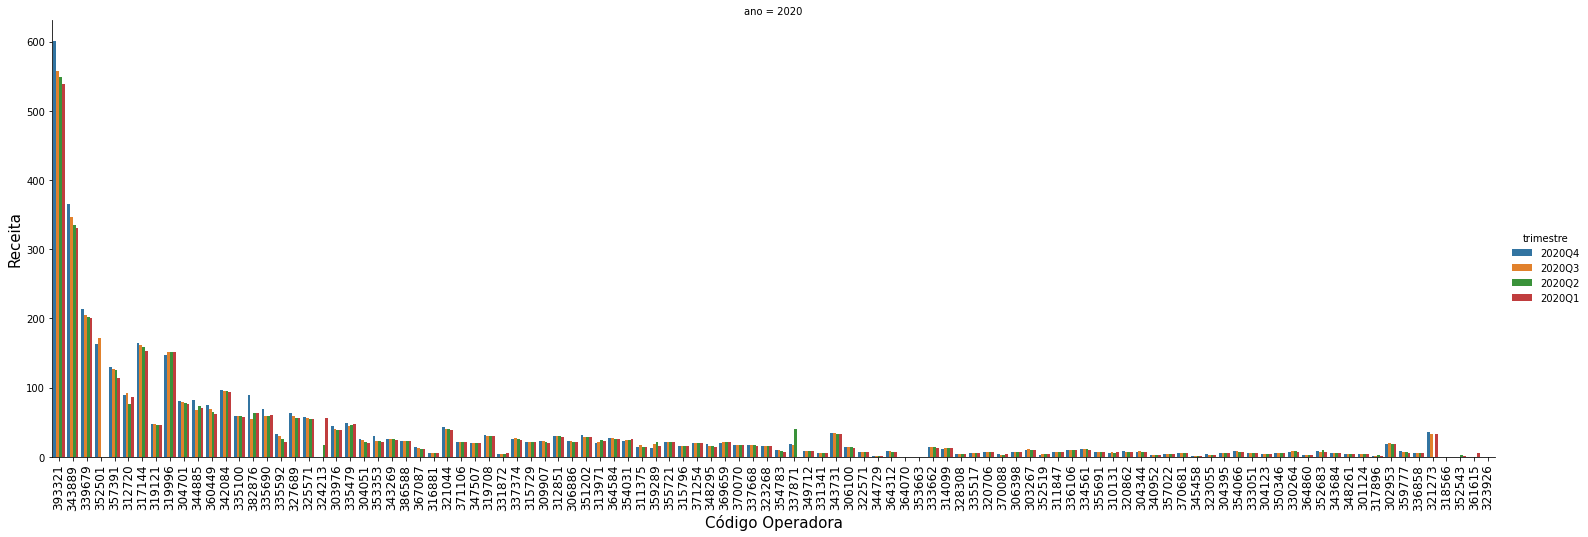

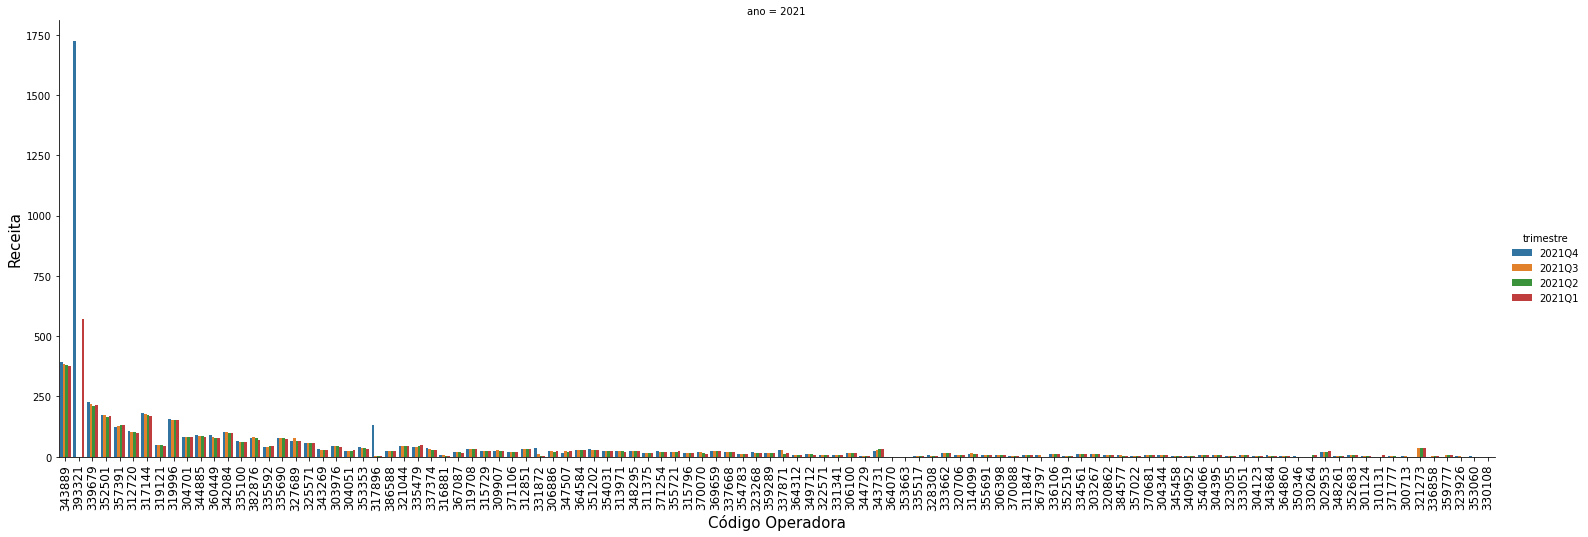

In [13]:
df_plot = ans_filt_cont_mod_agrup_ops.copy()

fig, ax = plt.subplots(4)

#ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)
ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)
ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)
ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)
ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

del df_plot

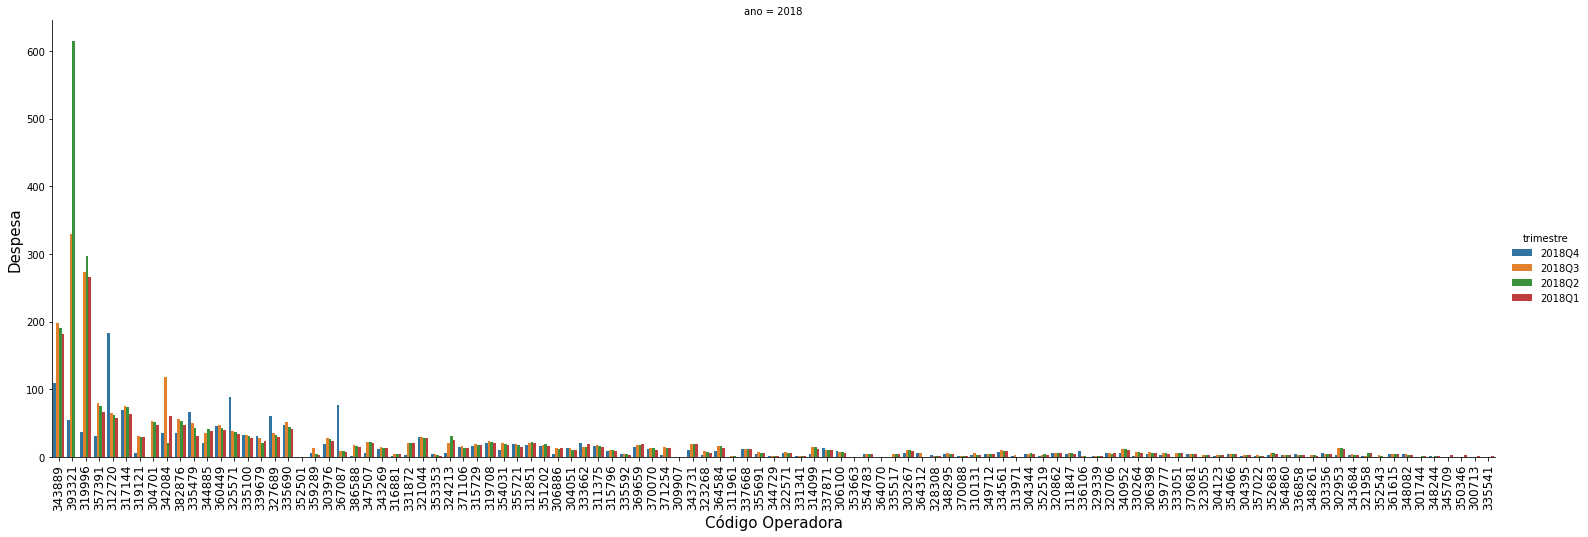

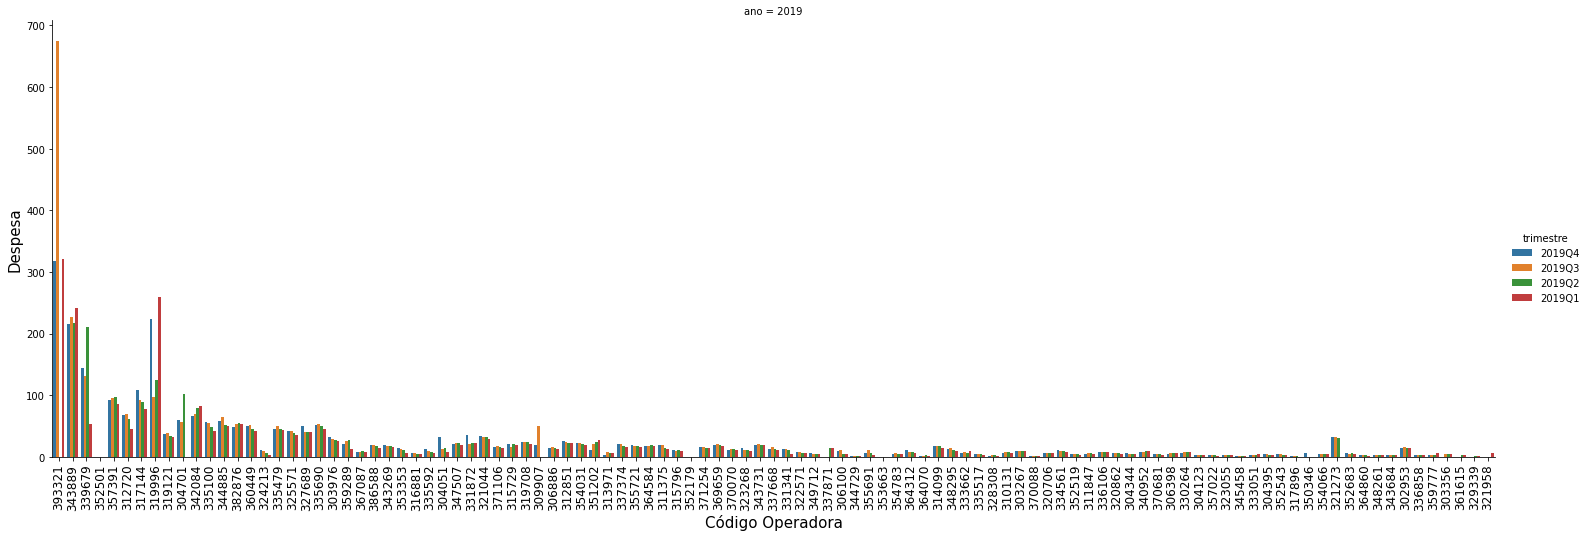

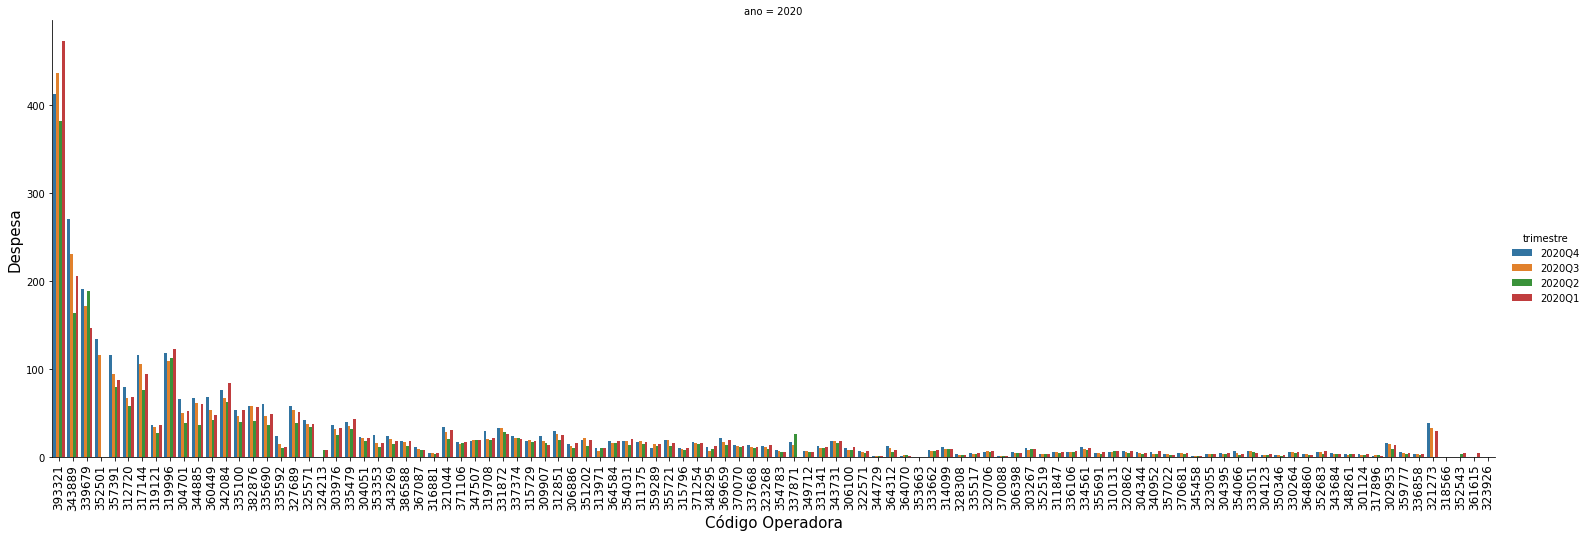

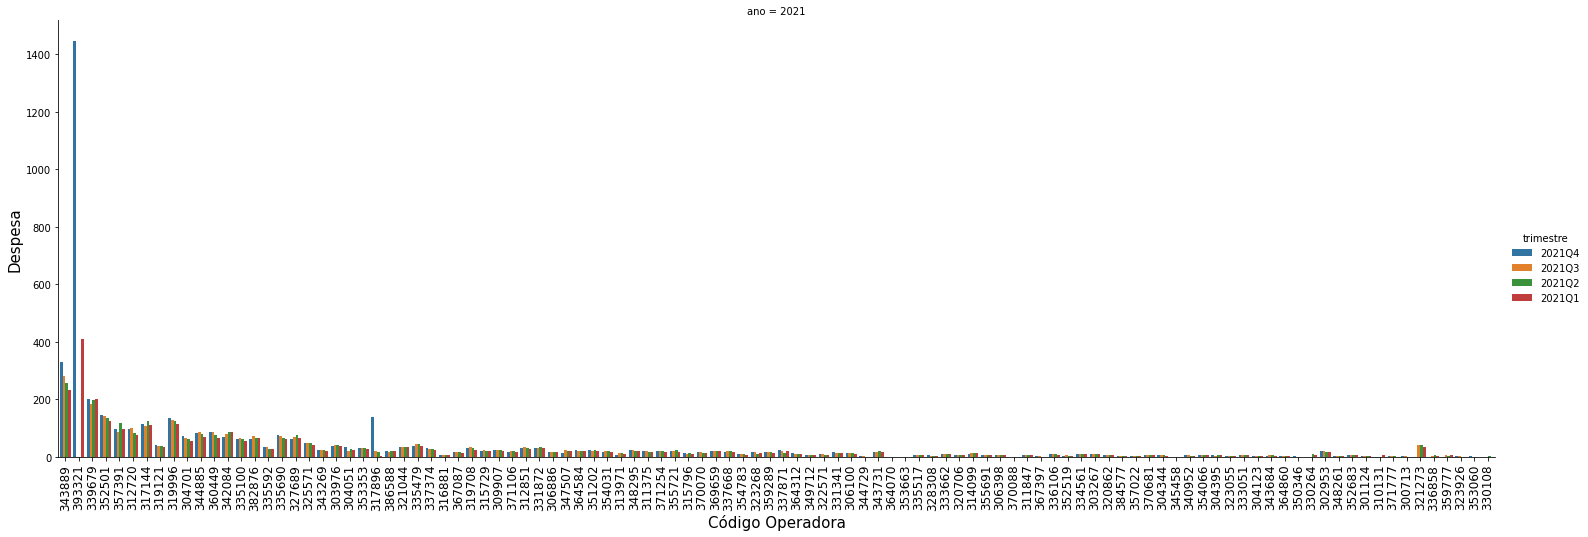

In [14]:
df_plot = ans_filt_cont_mod_agrup_ops.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)
ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)
ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)
ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

### Limpeza e Tratamento de Dados dos outliers

Nos gráficos acima é possivel observar que as curvas de receita e despesas possuem pontos outliers, provavelmente ocasionados pelo por erros de lançamentos das demonstrações contabeis.

E além disso, nos gráficos de barras por operadoras, mostra que muitas operadoras não possuem lançamentos em todos os trimestres do ano. Essas ausencias de lançamentos também ajudam no aparecimento de pontos outliers na evolução trimestral de receita e despesa.

Os códigos das células abaixo, tem com objetivo corrigir essas falhas de lançamentos de demontrações contabeis trimestrais. E na última parte do tratamento, possui o objetivo de corrigir alguns desvios do da curva de receita e depesa trimestral.

#### 1ª Etapa - Preenchendo lançamentos faltantes de algumas operadoras

In [15]:
#Agrupamento da receita e despesa de cada operadora por trimestre
ans_alterada1 = ans_filt_cont_mod.groupby(['ano','cd_ops','trimestre'], as_index=False).agg({'receita':'sum',
                                                                                             'despesa':'sum'})

ans_alterada1 = ans_alterada1[(ans_alterada1['ano']>'2017') & (ans_alterada1['ano']<'2022')] #Filtra anos de 2018 até 2021

ans_alterada1 = ans_alterada1.drop(ans_alterada1[(ans_alterada1.receita != 0) & (ans_alterada1.despesa == 0)].index)

ans_alterada1 = ans_alterada1.drop(ans_alterada1[(ans_alterada1.receita == 0) & (ans_alterada1.despesa != 0)].index)

ans_alterada1 = ans_alterada1.drop(ans_alterada1[(ans_alterada1.receita == 0) & (ans_alterada1.despesa == 0)].index)

display(ans_alterada1.head())

,ano,cd_ops,trimestre,receita,despesa
446,2018,300713,2018Q1,2962073.62000,1405863.51000
447,2018,300713,2018Q2,2231365.78000,1820915.15000
448,2018,300713,2018Q3,1406682.20000,2351203.34000
449,2018,300713,2018Q4,2321841.79000,1453821.05000
450,2018,301060,2018Q1,1177721.04000,449595.64000


In [16]:
#Identificação das operadora que não possuem os 4 lançamentos contabeis durante o ano, ou seja, existem algumas operadoras que possuem falhas na publicação des demonstrações de contabilidade
ans_alterada2 = ans_alterada1.groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))

display(ans_alterada2.head())

ans_alterada2.n_trimestre.unique()

,ano,cd_ops,n_trimestre
0,2018,300713,4
1,2018,301060,4
2,2018,301124,4
3,2018,301574,4
4,2018,301744,4


array([4, 3, 2, 1], dtype=int64)

In [17]:
#Operadoras com lançamento contabeis em todos os trimestres do período selecionado para o estudo
ans_alterada_complete = ans_alterada2[ans_alterada2['n_trimestre']==4].reset_index(drop=True)
ans_alterada_complete = ans_alterada_complete[['ano','cd_ops']]

display(ans_alterada_complete.info())

display(ans_alterada_complete.head())

#ans_alterada_complete[ans_alterada_complete['cd_ops']=='393321']

complete_ops_list = ans_alterada_complete['cd_ops'].to_numpy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905 entries, 0 to 904
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype        
---  ------  --------------  -----        
 0   ano     905 non-null    period[A-DEC]
 1   cd_ops  905 non-null    object       
dtypes: object(1), period[A-DEC](1)
memory usage: 14.3+ KB


None

,ano,cd_ops
0,2018,300713
1,2018,301060
2,2018,301124
3,2018,301574
4,2018,301744


In [18]:
#Operadoras com lançamento contabeis faltando em algum(uns) trimestre(s) do período selecionado para o estudo
ans_alterada_imcomplete = ans_alterada2[ans_alterada2['n_trimestre']!=4].reset_index(drop=True)
ans_alterada_imcomplete = ans_alterada_imcomplete[['ano','cd_ops']]

display(ans_alterada_imcomplete.info())

display(ans_alterada_imcomplete.head())

imcomplete_ops_list = ans_alterada_imcomplete['cd_ops'].to_numpy()

#ans_alterada_imcomplete[ans_alterada_imcomplete['cd_ops']=='393321']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype        
---  ------  --------------  -----        
 0   ano     32 non-null     period[A-DEC]
 1   cd_ops  32 non-null     object       
dtypes: object(1), period[A-DEC](1)
memory usage: 640.0+ bytes


None

,ano,cd_ops
0,2018,302228
1,2018,311961
2,2018,343765
3,2018,359033
4,2018,360414


In [19]:
diff_list = np.setdiff1d(complete_ops_list,imcomplete_ops_list)

ans_alterada_complete = ans_alterada_complete[ans_alterada_complete["cd_ops"].isin(diff_list)]

#Dataframe somente com as operadoras com lançamentos completos
display(ans_alterada_complete.info())

display(ans_alterada_complete.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 865 entries, 0 to 903
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype        
---  ------  --------------  -----        
 0   ano     865 non-null    period[A-DEC]
 1   cd_ops  865 non-null    object       
dtypes: object(1), period[A-DEC](1)
memory usage: 20.3+ KB


None

,ano,cd_ops
0,2018,300713
1,2018,301060
2,2018,301124
3,2018,301574
4,2018,301744


In [20]:
#Filtra as operadoras com lançamentos completos
keys = list(ans_alterada_complete.columns.values)
i1 = ans_alterada1.set_index(keys).index
i2 = ans_alterada_complete.set_index(keys).index

ans_alterada3 =  ans_alterada1[i1.isin(i2)]

#Dataframe somente com dados das operadoras que possuem lançamento em todos os trimestre dos anos estudados neste trabalho
display(ans_alterada3.head())

#Verificação da filtragem
ans_alterada3_vef = ans_alterada3[(ans_alterada3['ano']>'2017') & (ans_alterada3['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
ans_alterada3_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
446,2018,300713,2018Q1,2962073.62000,1405863.51000
447,2018,300713,2018Q2,2231365.78000,1820915.15000
448,2018,300713,2018Q3,1406682.20000,2351203.34000
449,2018,300713,2018Q4,2321841.79000,1453821.05000
450,2018,301060,2018Q1,1177721.04000,449595.64000


array([4], dtype=int64)

In [21]:
#Cálculo do percentual de crescimento trimestral das receitas e despesas

#Este percentual será utilizado para corrigir os pontos outliers para as operadoras com lançamentos imcompletos

ans_alterada3['ref1'] = (   ans_alterada3['ano'].map(str) + 
                            ans_alterada3['cd_ops'].map(str))

ans_alterada3['ref2'] = (   ans_alterada3['ano'].map(str) + 
                            ans_alterada3['cd_ops'].map(str)+
                            ans_alterada3['trimestre'].map(str))

ans_alterada3[['receita_shifted','despesa_shifted']] = ans_alterada3[['ref1','ref2','receita','despesa']].groupby(['ref1'])[['receita','despesa']].shift()

ans_alterada3['pct_tri_receita'] = ((ans_alterada3['receita'] / ans_alterada3['receita_shifted'])) 
ans_alterada3['pct_tri_despesa'] = ((ans_alterada3['despesa'] / ans_alterada3['despesa_shifted'])) 
 
ans_alterada3 = ans_alterada3[['ano','cd_ops','trimestre','receita','receita_shifted','pct_tri_receita','despesa','despesa_shifted','pct_tri_despesa']].fillna(0)

ans_alterada3.head()

,ano,cd_ops,trimestre,receita,receita_shifted,pct_tri_receita,despesa,despesa_shifted,pct_tri_despesa
446,2018,300713,2018Q1,2962073.62000,0.00000,0.00000,1405863.51000,0.00000,0.00000
447,2018,300713,2018Q2,2231365.78000,2962073.62000,0.75331,1820915.15000,1405863.51000,1.29523
448,2018,300713,2018Q3,1406682.20000,2231365.78000,0.63041,2351203.34000,1820915.15000,1.29122
449,2018,300713,2018Q4,2321841.79000,1406682.20000,1.65058,1453821.05000,2351203.34000,0.61833
450,2018,301060,2018Q1,1177721.04000,0.00000,0.00000,449595.64000,0.00000,0.00000


In [22]:
#Estatisticas referentes aos percentuais calculados na celula anterior

stats_ans_alterada = pd.DataFrame(ans_alterada3.groupby(['ano','trimestre'])[['pct_tri_receita','pct_tri_despesa']].describe(percentiles = [.25,.5,.75]))

stats_ans_alterada = stats_ans_alterada.reset_index(level=[0,1])

stats_ans_alterada.columns = ['_'.join(col) for col in stats_ans_alterada.columns.values]

stats_ans_alterada = stats_ans_alterada[['ano_','trimestre_','pct_tri_receita_25%', 'pct_tri_receita_75%', 'pct_tri_despesa_25%', 'pct_tri_despesa_75%']]

stats_ans_alterada.rename(columns = {'ano_':'ano',
                                     'trimestre_':'trimestre',
                                     'pct_tri_receita_25%':'pct_tri_receita_25',
                                     'pct_tri_receita_75%':'pct_tri_receita_75',
                                     'pct_tri_despesa_25%':'pct_tri_despesa_25',
                                     'pct_tri_despesa_75%':'pct_tri_despesa_75'}, inplace = True)

#Dataframe com os principais quartis dos crescimento percentuais calculados anteriormente
stats_ans_alterada

,ano,trimestre,pct_tri_receita_25,pct_tri_receita_75,pct_tri_despesa_25,pct_tri_despesa_75
0,2018,2018Q1,0.00000,0.00000,0.00000,0.00000
1,2018,2018Q2,0.99295,1.05600,0.93156,1.21706
2,2018,2018Q3,0.99971,1.05804,0.95361,1.15363
3,2018,2018Q4,1.00253,1.06801,0.44500,1.09469
4,2019,2019Q1,0.00000,0.00000,0.00000,0.00000
5,2019,2019Q2,0.98370,1.05827,0.97271,1.31906
6,2019,2019Q3,0.99544,1.04498,0.89707,1.17882
7,2019,2019Q4,0.99829,1.05161,0.86788,1.11949
8,2020,2020Q1,0.00000,0.00000,0.00000,0.00000
9,2020,2020Q2,0.98859,1.03978,0.67149,0.91396


In [23]:
#Identificando as operadoras que estão dentro do intervalo inter-quartil calculado acima
#Essa filtragem ajuda no cálculo do percentual do crescimento médio de receita e despesa

ans_alterada4 =  pd.merge(ans_alterada3, stats_ans_alterada, how = 'left', on = ['ano','trimestre'])

#Filtragem das operadoras
ans_alterada4 = ans_alterada4[( (ans_alterada4['pct_tri_receita'] >= ans_alterada4['pct_tri_receita_25']) & 
                                (ans_alterada4['pct_tri_receita'] <= ans_alterada4['pct_tri_receita_75'])) &
                                ((ans_alterada4['pct_tri_despesa'] >= ans_alterada4['pct_tri_despesa_25']) & 
                                (ans_alterada4['pct_tri_despesa'] <= ans_alterada4['pct_tri_despesa_75']))]

ans_alterada4.head()

,ano,cd_ops,trimestre,receita,receita_shifted,pct_tri_receita,despesa,despesa_shifted,pct_tri_despesa,pct_tri_receita_25,pct_tri_receita_75,pct_tri_despesa_25,pct_tri_despesa_75
0,2018,300713,2018Q1,2962073.62000,0.00000,0.00000,1405863.51000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,2018,301060,2018Q1,1177721.04000,0.00000,0.00000,449595.64000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
8,2018,301124,2018Q1,2092732.85000,0.00000,0.00000,1396791.32000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
12,2018,301574,2018Q1,3559709.44000,0.00000,0.00000,3584395.42000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
14,2018,301574,2018Q3,3583680.38000,3541128.94000,1.01202,2862489.27000,2922531.12000,0.97946,0.99971,1.05804,0.95361,1.15363


In [24]:
#Calculo das estatisticas dos percentuais das operadoras filtradas na celula anterior
stats_ans_alterada2 = ans_alterada4.groupby(['ano','trimestre'])[['pct_tri_receita','pct_tri_despesa']].describe(percentiles = [.25,.5,.75])

stats_ans_alterada2 = stats_ans_alterada2.reset_index(level=[0,1])

stats_ans_alterada2.columns = ['_'.join(col) for col in stats_ans_alterada2.columns.values]

#Percentual mediano de crescimento da receita e despesa
stats_ans_alterada2 = stats_ans_alterada2[['ano_','trimestre_','pct_tri_receita_50%', 'pct_tri_despesa_50%']]

stats_ans_alterada2.rename(columns = {'ano_':'ano',
                                      'trimestre_':'trimestre',
                                      'pct_tri_receita_50%':'pct_tri_receita_50',
                                      'pct_tri_despesa_50%':'pct_tri_despesa_50'}, inplace = True)

#Dataframe com o crescimento mediano para trimestre dos anos abordados neste estudo
stats_ans_alterada2

,ano,trimestre,pct_tri_receita_50,pct_tri_despesa_50
0,2018,2018Q1,0.00000,0.00000
1,2018,2018Q2,1.02115,1.05870
2,2018,2018Q3,1.02185,1.04194
3,2018,2018Q4,1.02611,0.84797
4,2019,2019Q1,0.00000,0.00000
5,2019,2019Q2,1.01102,1.11778
6,2019,2019Q3,1.01955,1.04441
7,2019,2019Q4,1.01917,1.00418
8,2020,2020Q1,0.00000,0.00000
9,2020,2020Q2,1.00577,0.80112


In [25]:
#Substituindo pct iguais a zero por um
stats_ans_alterada2 = stats_ans_alterada2.replace(0.0, 1.0)

stats_ans_alterada2[['pct_tri_receita_50_l1','pct_tri_despesa_50_l1']] = stats_ans_alterada2.groupby(['ano'])[['pct_tri_receita_50','pct_tri_despesa_50']].shift()

stats_ans_alterada2.fillna(1.0, inplace=True)

#Calcula o percentual de crescimento acumulado entre trimestres
stats_ans_alterada2['pct_tri_receita_50_m1'] = stats_ans_alterada2['pct_tri_receita_50'] * stats_ans_alterada2['pct_tri_receita_50_l1']

stats_ans_alterada2['pct_tri_despesa_50_m1'] = stats_ans_alterada2['pct_tri_despesa_50'] * stats_ans_alterada2['pct_tri_despesa_50_l1']

stats_ans_alterada2[['pct_tri_receita_50_l2','pct_tri_despesa_50_l2']] = stats_ans_alterada2.groupby(['ano'])[['pct_tri_receita_50_m1','pct_tri_despesa_50_m1']].shift()

stats_ans_alterada2.fillna(1.0, inplace=True)

stats_ans_alterada2['pct_tri_receita_50_m2'] = stats_ans_alterada2['pct_tri_receita_50'] * stats_ans_alterada2['pct_tri_receita_50_l2']

stats_ans_alterada2['pct_tri_despesa_50_m2'] = stats_ans_alterada2['pct_tri_despesa_50'] * stats_ans_alterada2['pct_tri_despesa_50_l2']

stats_ans_alterada2 = stats_ans_alterada2[['ano','trimestre','pct_tri_receita_50_m2','pct_tri_despesa_50_m2']]

stats_ans_alterada2.rename(columns = {'pct_tri_receita_50_m2':'pct_tri_receita_50',
                                      'pct_tri_despesa_50_m2':'pct_tri_despesa_50'}, inplace = True)

#Dataframe com o percentual de crescimento acumulado
stats_ans_alterada2

,ano,trimestre,pct_tri_receita_50,pct_tri_despesa_50
0,2018,2018Q1,1.00000,1.00000
1,2018,2018Q2,1.02115,1.05870
2,2018,2018Q3,1.04346,1.10310
3,2018,2018Q4,1.07071,0.93539
4,2019,2019Q1,1.00000,1.00000
5,2019,2019Q2,1.01102,1.11778
6,2019,2019Q3,1.03079,1.16742
7,2019,2019Q4,1.05055,1.17230
8,2020,2020Q1,1.00000,1.00000
9,2020,2020Q2,1.00577,0.80112


In [26]:
#Identificação das operadas que nao possuem somente lançamentos de receita ou de despesa
keys = list(ans_alterada_complete.columns.values)
i1 = ans_alterada1.set_index(keys).index
i2 = ans_alterada_complete.set_index(keys).index

ans_alterada5 =  ans_alterada1[~i1.isin(i2)]

#Retira as operadoras que so possuem lançamentos de receita ou despesa
ans_alterada5 = ans_alterada5[((ans_alterada5['receita']!=0.0)&(ans_alterada5['despesa']!=0.0))]

display(ans_alterada5.head())

#display(ans_alterada5[ans_alterada5['cd_ops']=='393321'])

ans_alterada5_vef = ans_alterada5[(ans_alterada5['ano']>'2017') & (ans_alterada5['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
ans_alterada5_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
466,2018,302228,2018Q2,1825033.35000,1501749.27000
467,2018,302228,2018Q3,773539.10000,556168.47000
468,2018,302228,2018Q4,732106.13000,1796298.64000
509,2018,304701,2018Q1,62579570.01000,46833889.30000
510,2018,304701,2018Q2,64299193.74000,51025217.13000


array([3, 4, 2, 1], dtype=int64)

In [27]:
#Agrupamento duplo, ou seja, agurpamento da receita e despesa por operadora e trimestre
ans_alterada6 = ans_alterada5[['cd_ops','trimestre','receita','despesa']]
ans_alterada6 = ans_alterada6.set_index(['cd_ops','trimestre'])
mux = pd.MultiIndex.from_product([ans_alterada6.index.levels[0], ans_alterada6.index.levels[1]],names=['cd_ops','trimestre'])
ans_alterada6 = ans_alterada6.reindex(mux, fill_value=0).reset_index()

ans_alterada6['ano'] = ans_alterada6['trimestre'].dt.year

ans_alterada6['ano'] = ans_alterada6['ano'].apply(pd.Period, freq='A-DEC')

ans_alterada6 = ans_alterada6[['ano','cd_ops','trimestre','receita','despesa']]

ans_alterada6.sort_values(by=['ano','cd_ops'], ignore_index=True, inplace=True)

#ans_alterada6[ans_alterada6['cd_ops']=='393321']

ans_alterada6.head()

,ano,cd_ops,trimestre,receita,despesa
0,2018,302228,2018Q1,0.00000,0.00000
1,2018,302228,2018Q2,1825033.35000,1501749.27000
2,2018,302228,2018Q3,773539.10000,556168.47000
3,2018,302228,2018Q4,732106.13000,1796298.64000
4,2018,304468,2018Q1,0.00000,0.00000


In [28]:
#Criação de um dataframe com os valores anuais de receita e despesa
ans_alterada7 = ans_alterada6.groupby(['ano','cd_ops'], as_index=False).agg({   'receita': 'sum',
                                                                                'despesa': 'sum'})

#Criação dos campos de receita e despesa anuais dividida por 4
ans_alterada7['receita_tri'] = ans_alterada7['receita'] / 4.0
ans_alterada7['despesa_tri'] = ans_alterada7['despesa'] / 4.0

ans_alterada7.head()

,ano,cd_ops,receita,despesa,receita_tri,despesa_tri
0,2018,302228,3330678.58000,3854216.38000,832669.64500,963554.09500
1,2018,304468,0.00000,0.00000,0.00000,0.00000
2,2018,304701,260869646.84000,150585235.17000,65217411.71000,37646308.79250
3,2018,309907,0.00000,0.00000,0.00000,0.00000
4,2018,310131,18323833.10000,13247102.87000,4580958.27500,3311775.71750


In [29]:
ans_alterada8 =  pd.merge(ans_alterada6, ans_alterada7[['ano','cd_ops','receita_tri','despesa_tri']], how = 'outer', on = ['ano','cd_ops'])

ans_alterada8 = ans_alterada8[['ano','cd_ops','trimestre','receita_tri','despesa_tri']]

ans_alterada8.rename(columns = {'receita_tri':'receita', 'despesa_tri':'despesa'}, inplace = True)

#Retira as operadoras que possuem receita ou despesa iguais a zero
ans_alterada8 = ans_alterada8.drop(ans_alterada8[(ans_alterada8.receita == 0) & (ans_alterada8.despesa == 0)].index)

#Retira as operadoras que possuem receita ou despesa negativos
ans_alterada8 = ans_alterada8.drop(ans_alterada8[(ans_alterada8.receita < 1.0) | (ans_alterada8.despesa < 1.0)].index)

#ans_alterada8[ans_alterada8['cd_ops']=='393321']

#Dataframe com total de receita e despesa distribuido de forma uniforme nos 4 trimestre de cada ano
ans_alterada8.head()

#ans_alterada8_vef = ans_alterada8[(ans_alterada8['ano']>'2017') & (ans_alterada8['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
#ans_alterada8_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
0,2018,302228,2018Q1,832669.64500,963554.09500
1,2018,302228,2018Q2,832669.64500,963554.09500
2,2018,302228,2018Q3,832669.64500,963554.09500
3,2018,302228,2018Q4,832669.64500,963554.09500
8,2018,304701,2018Q1,65217411.71000,37646308.79250


In [30]:
#Aplicando o percentual de crescimento ao df com os valores distribuido de forma igual a cada trimestre
ans_alterada9 = pd.merge(ans_alterada8,stats_ans_alterada2, on=['ano','trimestre'])

ans_alterada9['receita_m1'] = ans_alterada9['receita'] * ans_alterada9['pct_tri_receita_50']

ans_alterada9['despesa_m1'] = ans_alterada9['despesa'] * ans_alterada9['pct_tri_despesa_50']

ans_alterada9 = ans_alterada9[['ano','cd_ops','trimestre','receita_m1','despesa_m1']]

ans_alterada9.rename(columns = {'receita_m1':'receita', 'despesa_m1':'despesa'}, inplace = True)

#ans_alterada9[ans_alterada9['cd_ops']=='393321']
 
ans_alterada9.head()

,ano,cd_ops,trimestre,receita,despesa
0,2018,302228,2018Q1,832669.64500,963554.09500
1,2018,304701,2018Q1,65217411.71000,37646308.79250
2,2018,310131,2018Q1,4580958.27500,3311775.71750
3,2018,311961,2018Q1,2251731.37250,429763.70000
4,2018,334847,2018Q1,310344.71500,148943.13000


In [31]:
# Calculando as diferenças dos valores totais de receita e despesa antes e depois da correção
ans_alterada10 = ans_alterada9.groupby(['ano','cd_ops'], as_index=False).agg({  'receita': 'sum',
                                                                                'despesa': 'sum'})

ans_alterada10.rename(columns = {'receita':'receita2', 'despesa':'despesa2'}, inplace = True)

ans_alterada10 = pd.merge(ans_alterada10, ans_alterada7, on=['ano','cd_ops'])

ans_alterada10 = ans_alterada10[['ano','cd_ops','receita','despesa','receita2','despesa2']]

ans_alterada10['receita_diff'] = ans_alterada10['receita2'] - ans_alterada10['receita']

ans_alterada10['despesa_diff'] = ans_alterada10['despesa2'] - ans_alterada10['despesa']

ans_alterada10['receita_tri_diff'] = ans_alterada10['receita_diff'] / 4.0
ans_alterada10['despesa_tri_diff'] = ans_alterada10['despesa_diff'] / 4.0

ans_alterada10 = ans_alterada10[['ano','cd_ops','receita_tri_diff','despesa_tri_diff']]

ans_alterada10.head()

,ano,cd_ops,receita_tri_diff,despesa_tri_diff
0,2018,302228,28168.36736,23412.26057
1,2018,304701,2206238.71933,914723.10242
2,2018,310131,154969.16012,80468.91863
3,2018,311961,76173.78257,10442.31952
4,2018,334847,10498.64612,3618.99284


In [32]:
#Corrigindo as diferenças
ans_alterada11 =  pd.merge(ans_alterada9, ans_alterada10, how = 'outer', on = ['ano','cd_ops'])

ans_alterada11['receita_final'] = ans_alterada11['receita'] - ans_alterada11['receita_tri_diff']

ans_alterada11['despesa_final'] = ans_alterada11['despesa'] - ans_alterada11['despesa_tri_diff']

ans_alterada11 = ans_alterada11[['ano','cd_ops','trimestre','receita_final','despesa_final']]

ans_alterada11.rename(columns = {'receita_final':'receita', 'despesa_final':'despesa'}, inplace = True)

ans_alterada11.head()

#ans_alterada11[ans_alterada11['cd_ops']=='304701']

,ano,cd_ops,trimestre,receita,despesa
0,2018,302228,2018Q1,804501.27764,940141.83443
1,2018,302228,2018Q2,822111.78026,996702.44224
2,2018,302228,2018Q3,840689.07015,1039484.12316
3,2018,302228,2018Q4,863376.45195,877887.98018
4,2018,304701,2018Q1,63011172.99067,36731585.69008


In [33]:
ans_alterada12 = ans_alterada11.groupby(['ano','cd_ops'], as_index=False).agg({ 'receita': 'sum',
                                                                                'despesa': 'sum'})

ans_alterada12['receita_tri'] = ans_alterada12['receita'] / 4.0
ans_alterada12['despesa_tri'] = ans_alterada12['despesa'] / 4.0

ans_alterada12.head()

,ano,cd_ops,receita,despesa,receita_tri,despesa_tri
0,2018,302228,3330678.58000,3854216.38000,832669.64500,963554.09500
1,2018,304701,260869646.84000,150585235.17000,65217411.71000,37646308.79250
2,2018,310131,18323833.10000,13247102.87000,4580958.27500,3311775.71750
3,2018,311961,9006925.49000,1719054.80000,2251731.37250,429763.70000
4,2018,334847,1241378.86000,595772.52000,310344.71500,148943.13000


In [34]:
ans_alterada13 = ans_alterada3[['ano','cd_ops','trimestre','receita','despesa']]

ans_alterada14 = pd.concat([ans_alterada13, ans_alterada11], ignore_index=True)

#diops_tcc_analise14[diops_tcc_analise14['cd_ops']=='304701']

ans_alterada14.head()

#diops_tcc_analise_vef = diops_tcc_analise14[(diops_tcc_analise14['ano']>'2017') & (diops_tcc_analise14['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
#diops_tcc_analise_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
0,2018,300713,2018Q1,2962073.62000,1405863.51000
1,2018,300713,2018Q2,2231365.78000,1820915.15000
2,2018,300713,2018Q3,1406682.20000,2351203.34000
3,2018,300713,2018Q4,2321841.79000,1453821.05000
4,2018,301060,2018Q1,1177721.04000,449595.64000


In [35]:
#Criação do dataframe com receita e despesa agregados a partir das informações com os lançamentos faltantes corrigidos
ans_alterada15 = ans_alterada14.groupby(['ano','trimestre'], as_index=False).agg({  'receita':lambda x: sum_billion(x),
                                                                                    'despesa':lambda x: sum_billion(x),
                                                                                    'cd_ops':lambda x: x.nunique()})

ans_alterada15['pct_despesa'] = ans_alterada15.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_alterada15.columns = ['ano', 'trimestre', 'receita', 'despesa', 'n_ops', 'pct_despesa']

ans_alterada15 = ans_alterada15[['trimestre','receita','despesa','n_ops','pct_despesa']]

ans_alterada15.set_index('trimestre', inplace=True)

ans_alterada15

,receita,despesa,n_ops,pct_despesa
trimestre,,,,
2018Q1,2.87000,2.12000,225,73.87000
2018Q2,2.87000,2.26000,225,78.75000
2018Q3,3.09000,2.42000,225,78.32000
2018Q4,3.39000,1.92000,225,56.64000
2019Q1,3.23000,2.47000,234,76.47000
2019Q2,3.31000,2.69000,234,81.27000
2019Q3,3.42000,2.71000,234,79.24000
2019Q4,3.53000,2.87000,234,81.30000
2020Q1,3.68000,2.81000,237,76.36000


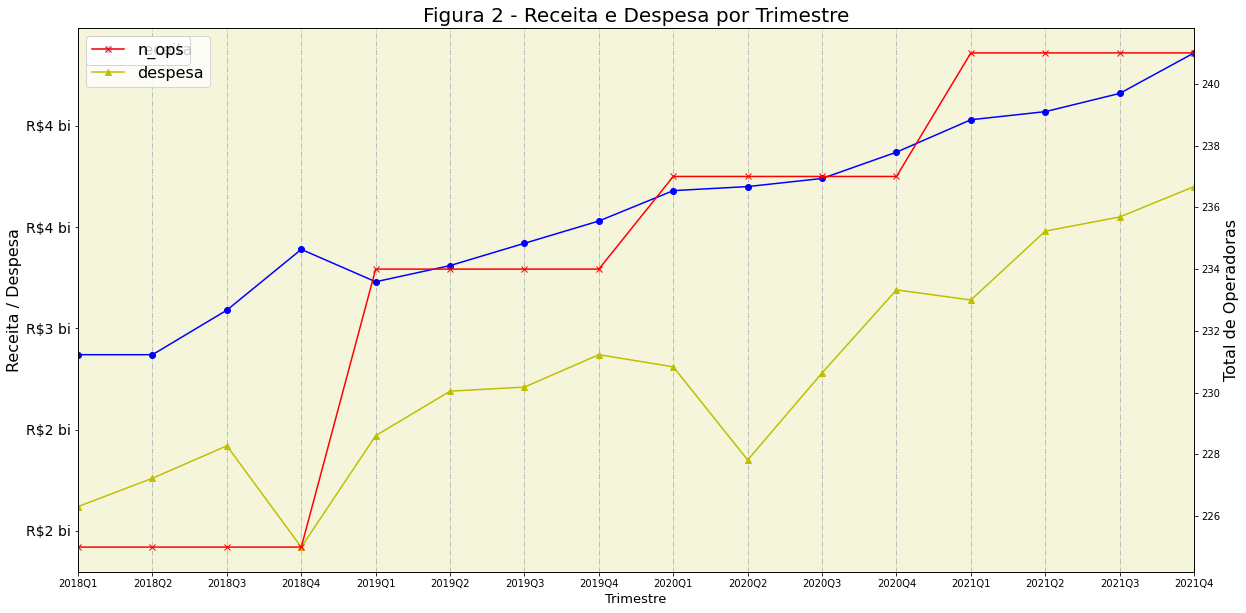

In [36]:
from importlib.metadata import metadata


df_plot = ans_alterada15.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 14)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.savefig('ade_coopmed_01.png',
 bbox_inches="tight",
 pad_inches=1,
 facecolor='w')

plt.show()

del df_plot

In [37]:
#Cria o rankin das operadoras com maior receita e despesa
ans_alterada16 = ans_alterada14.groupby(['ano','cd_ops'], as_index=False).agg({ 'receita':lambda x: sum_million(x),
                                                                                'despesa':lambda x: sum_million(x)})

ans_alterada16.sort_values(by=['ano','receita'], ascending=[True,False], inplace=True)

ans_alterada16.head()

,ano,cd_ops,receita,despesa
221,2018,393321,1801.06000,997.92000
61,2018,319996,1366.48000,871.97000
124,2018,343889,1101.39000,678.26000
54,2018,317144,423.86000,281.22000
177,2018,357391,394.20000,252.09000


In [38]:
ans_alterada_ops = ans_alterada16.head(100)

ans_alterada_ops = ans_alterada_ops[['cd_ops']].reset_index(drop=True)

keys = list(ans_alterada_ops.columns.values)
i1 = ans_alterada14.set_index(keys).index
i2 = ans_alterada_ops.set_index(keys).index

ans_alterada16 =  ans_alterada14[i1.isin(i2)]

ans_alterada16.sort_values(by=['receita'], ascending=False, inplace=True)

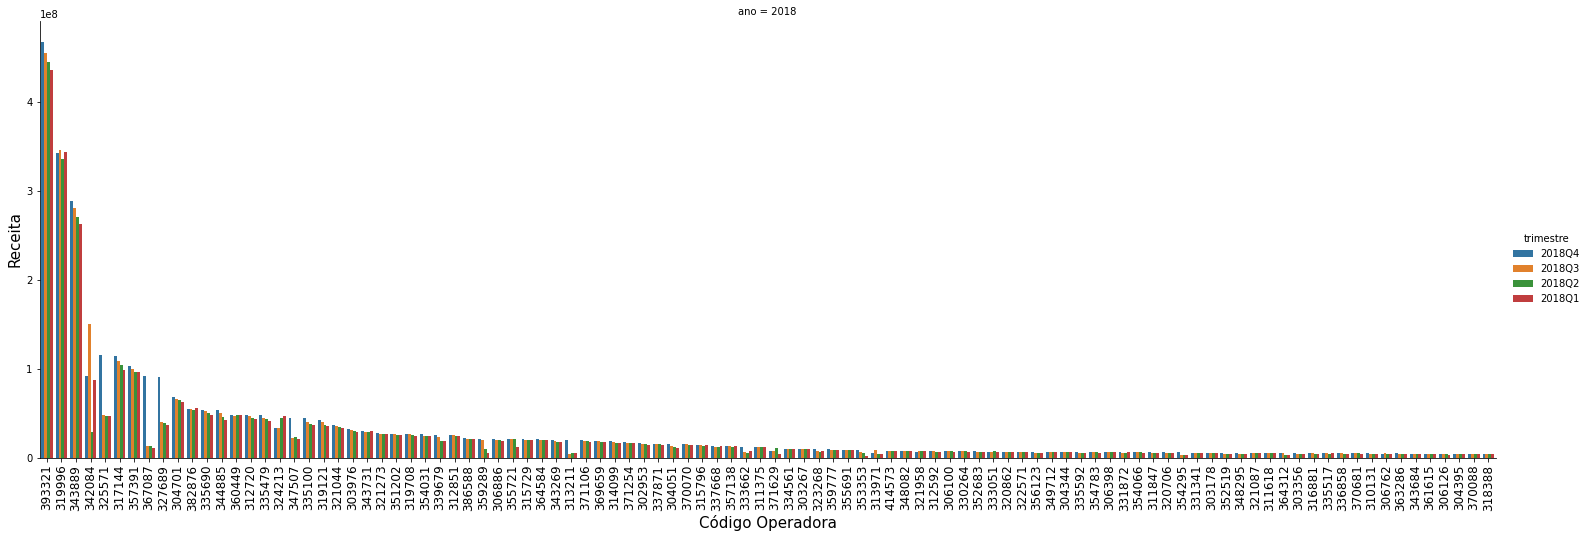

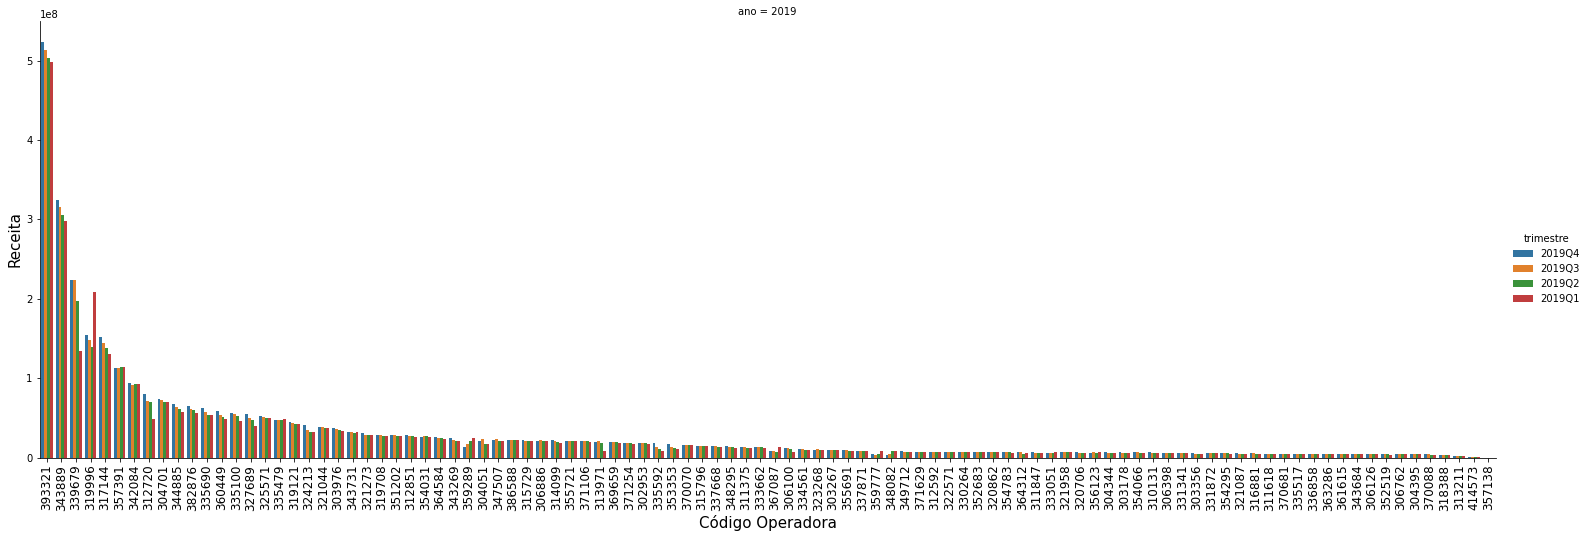

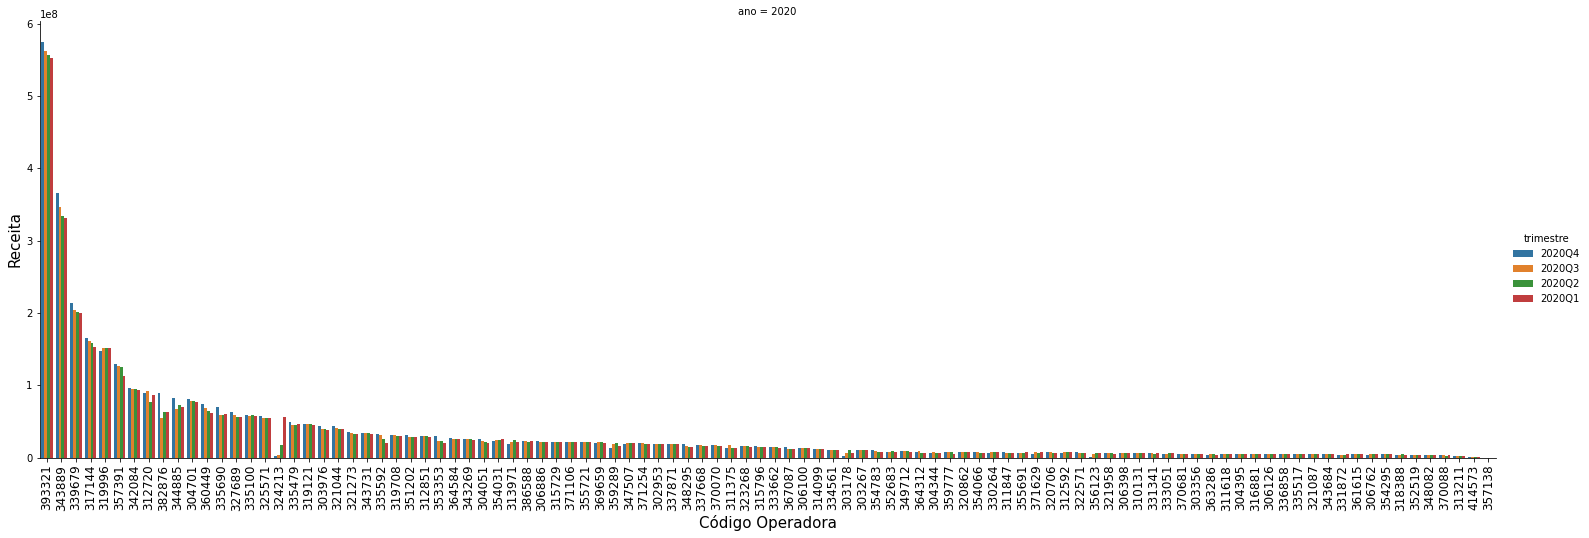

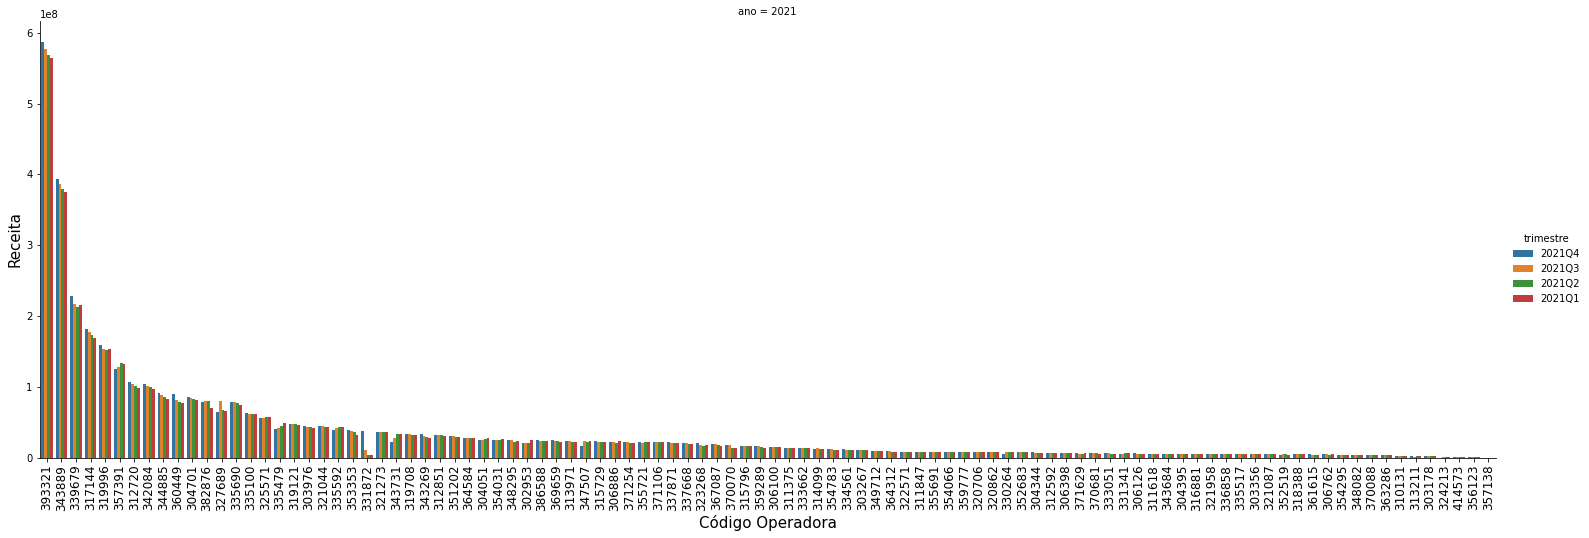

In [39]:
df_plot = ans_alterada16.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

del df_plot

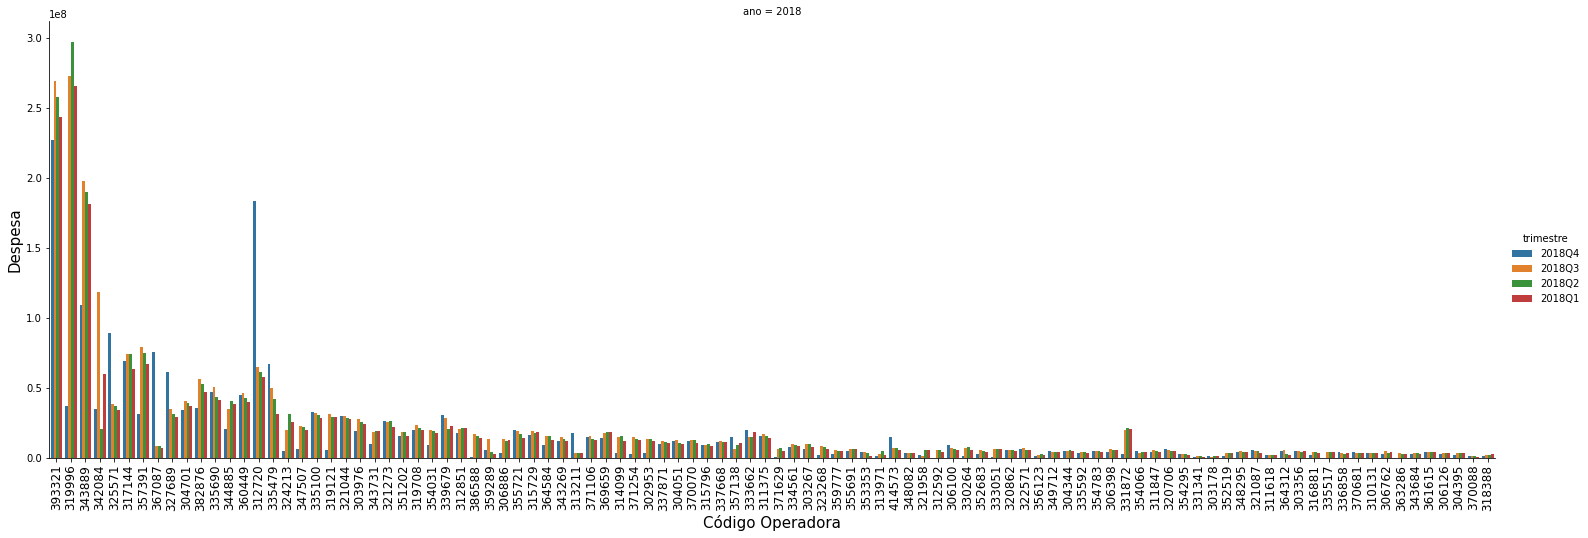

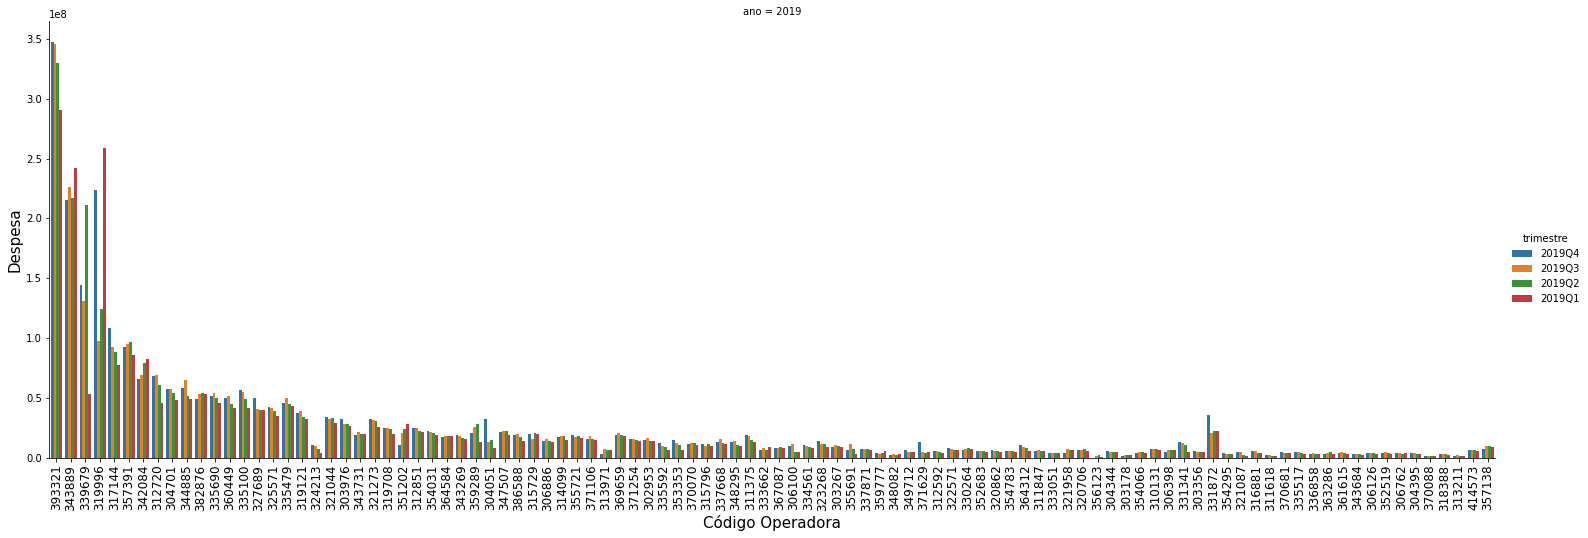

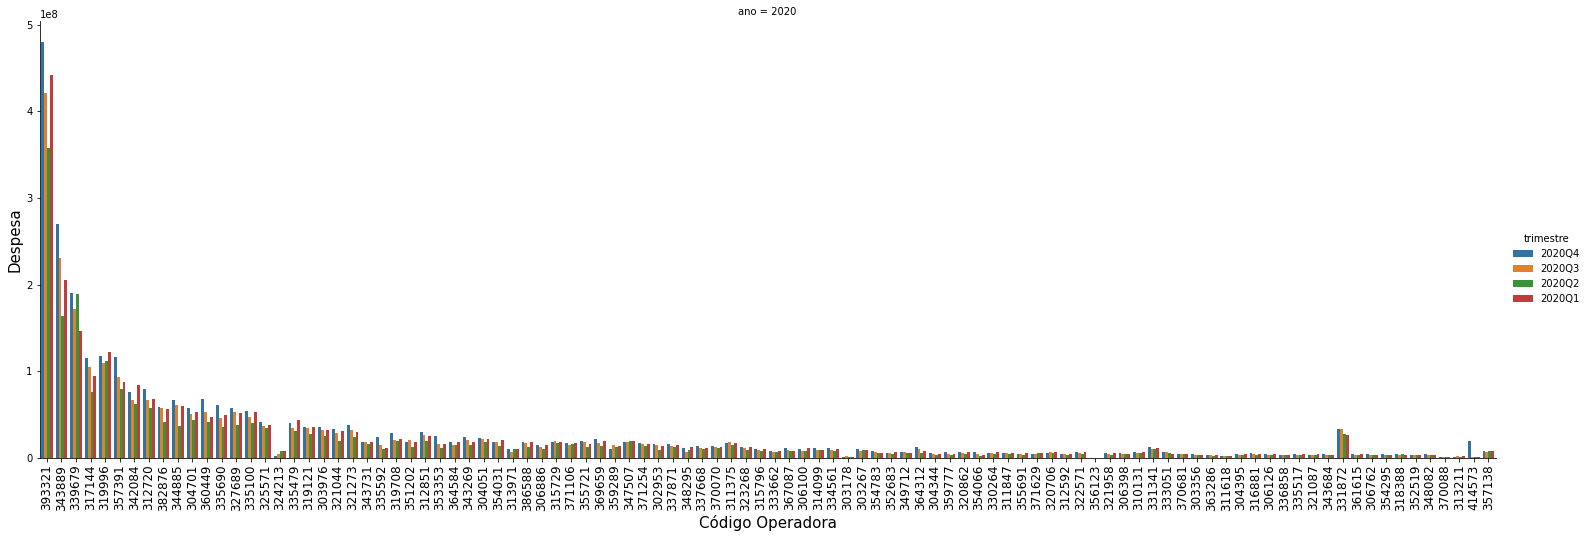

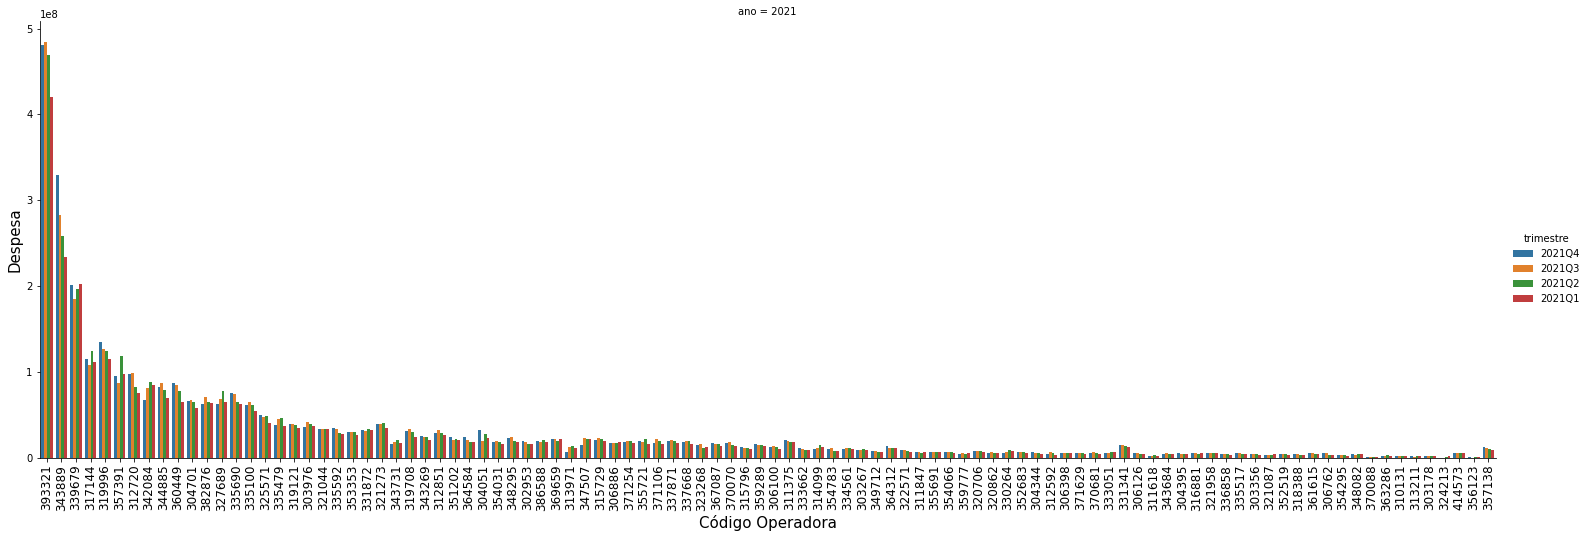

In [40]:
df_plot = ans_alterada16.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

del df_plot

### 2ª Etapa

Corrigindo alguns pontos outliers que nao acompanham o crescimento médio da curva de receita e despesa

In [41]:
#Base com a quantidade de operadoras corrigida

display(ans_alterada14.info())

display(ans_alterada14.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3748 entries, 0 to 3747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype        
---  ------     --------------  -----        
 0   ano        3748 non-null   period[A-DEC]
 1   cd_ops     3748 non-null   object       
 2   trimestre  3748 non-null   period[Q-DEC]
 3   receita    3748 non-null   float64      
 4   despesa    3748 non-null   float64      
dtypes: float64(2), object(1), period[A-DEC](1), period[Q-DEC](1)
memory usage: 146.5+ KB


None

,ano,cd_ops,trimestre,receita,despesa
0,2018,300713,2018Q1,2962073.62000,1405863.51000
1,2018,300713,2018Q2,2231365.78000,1820915.15000
2,2018,300713,2018Q3,1406682.20000,2351203.34000
3,2018,300713,2018Q4,2321841.79000,1453821.05000
4,2018,301060,2018Q1,1177721.04000,449595.64000


In [42]:
ans_alterada16 = ans_alterada14.groupby(['ano','cd_ops'], as_index=False).agg(  receita_total = ('receita','sum'),
                                                                                despesa_total = ('despesa','sum'))

ans_alterada17 = pd.merge(ans_alterada14,ans_alterada16, how='left', on=['ano','cd_ops'])

#Escolha do ano que possui pontos fora a curva média de crescimento da receita e despesa
ans_alterada17 = ans_alterada17[(ans_alterada17['ano']=='2018')]

ans_alterada17['pct_receita'] = ans_alterada17['receita'] / ans_alterada17['receita_total']
ans_alterada17['pct_despesa'] = ans_alterada17['despesa'] / ans_alterada17['despesa_total']

ans_alterada17.head()

,ano,cd_ops,trimestre,receita,despesa,receita_total,despesa_total,pct_receita,pct_despesa
0,2018,300713,2018Q1,2962073.62000,1405863.51000,8921963.39000,7031803.05000,0.33200,0.19993
1,2018,300713,2018Q2,2231365.78000,1820915.15000,8921963.39000,7031803.05000,0.25010,0.25895
2,2018,300713,2018Q3,1406682.20000,2351203.34000,8921963.39000,7031803.05000,0.15767,0.33437
3,2018,300713,2018Q4,2321841.79000,1453821.05000,8921963.39000,7031803.05000,0.26024,0.20675
4,2018,301060,2018Q1,1177721.04000,449595.64000,4777162.00000,1742318.86000,0.24653,0.25804


In [43]:
#calculado o valor limite dos outliers
stats_ans_alterada3 = ans_alterada17.groupby(['ano','trimestre'])[['pct_receita','pct_despesa']].describe(percentiles = [.51])

stats_ans_alterada3

pct_receita                                                 pct_despesa                                                
                     count    mean     std     min     50%     51%     max       count    mean     std     min     50%     51%     max
ano  trimestre                                                                                                                        
2018 2018Q1      225.00000 0.23098 0.05254 0.00590 0.24077 0.24139 0.56904   225.00000 0.24205 0.07784 0.00016 0.24393 0.24393 0.57973
     2018Q2      225.00000 0.23717 0.04486 0.00568 0.24551 0.24557 0.41714   225.00000 0.25887 0.08049 0.00216 0.25860 0.25869 0.72309
     2018Q3      225.00000 0.24887 0.04465 0.00907 0.25241 0.25241 0.41943   225.00000 0.27144 0.07712 0.00559 0.26970 0.26985 0.65121
     2018Q4      225.00000 0.28298 0.10631 0.04853 0.25989 0.26013 0.97331   225.00000 0.22763 0.15615 0.00493 0.22777 0.22777 0.98819

In [44]:
stats_ans_alterada4 = stats_ans_alterada3.reset_index(level=[0,1])

stats_ans_alterada4.columns = ['_'.join(col) for col in stats_ans_alterada4.columns.values]

stats_ans_alterada4 = stats_ans_alterada4[['ano_','trimestre_','pct_receita_mean','pct_despesa_mean','pct_receita_50%','pct_despesa_50%','pct_receita_51%', 'pct_despesa_51%']]

stats_ans_alterada4.rename(columns = {'ano_':'ano',
                                      'trimestre_':'trimestre',
                                      'pct_receita_50%':'pct_receita_50',
                                      'pct_despesa_50%':'pct_despesa_50',
                                      'pct_receita_51%':'pct_receita_ref',
                                      'pct_despesa_51%':'pct_despesa_ref'}, inplace = True)

stats_ans_alterada4

,ano,trimestre,pct_receita_mean,pct_despesa_mean,pct_receita_50,pct_despesa_50,pct_receita_ref,pct_despesa_ref
0,2018,2018Q1,0.23098,0.24205,0.24077,0.24393,0.24139,0.24393
1,2018,2018Q2,0.23717,0.25887,0.24551,0.25860,0.24557,0.25869
2,2018,2018Q3,0.24887,0.27144,0.25241,0.26970,0.25241,0.26985
3,2018,2018Q4,0.28298,0.22763,0.25989,0.22777,0.26013,0.22777


In [45]:
ans_alterada18 = pd.merge(ans_alterada17,stats_ans_alterada4[['ano','trimestre','pct_receita_mean','pct_despesa_mean','pct_receita_50','pct_despesa_50','pct_receita_ref','pct_despesa_ref']], how='left', on=['ano','trimestre'])

ans_alterada18['receita_mean'] = ans_alterada18['receita_total'] * ans_alterada18['pct_receita_50']

ans_alterada18['despesa_mean'] = ans_alterada18['despesa_total'] * ans_alterada18['pct_despesa_50']

ans_alterada18 = ans_alterada18[['ano','cd_ops','trimestre','receita_mean','despesa_mean']]

#diops_tcc_analise18[diops_tcc_analise18['cd_ops']=='300012']

ans_alterada18.head()

,ano,cd_ops,trimestre,receita_mean,despesa_mean
0,2018,300713,2018Q1,2148143.85018,1715236.39748
1,2018,300713,2018Q2,2190403.55976,1818428.07519
2,2018,300713,2018Q3,2251972.66145,1896480.86848
3,2018,300713,2018Q4,2318692.40672,1601657.70885
4,2018,301060,2018Q1,1150198.75368,424996.07902


In [46]:
#Filtrando as operadora que possuem receita percentual ou despesa percentual acima da média do grupo
ans_alterada19 = pd.merge(ans_alterada17,stats_ans_alterada4, how='left', on=['ano','trimestre'])

ans_alterada19 = ans_alterada19[(ans_alterada19['pct_receita'] > ans_alterada19['pct_receita_ref'])]

ans_alterada19 = ans_alterada19[['ano','cd_ops','trimestre','receita','despesa']]

ans_alterada19.sort_values(by=['ano'], ascending=[True], ignore_index=True, inplace=True)

ans_alterada19.head()

,ano,cd_ops,trimestre,receita,despesa
0,2018,300713,2018Q1,2962073.62000,1405863.51000
1,2018,354066,2018Q1,5785109.40000,4290489.04000
2,2018,354031,2018Q4,26203773.39000,9326197.42000
3,2018,353876,2018Q4,1085107.49000,884577.94000
4,2018,353876,2018Q3,1063825.96000,1061087.14000


In [47]:
ans_alterada20 = pd.merge(ans_alterada19,ans_alterada18, how='left', on=['ano','cd_ops','trimestre'])

ans_alterada20 = ans_alterada20[['ano','cd_ops','trimestre','receita_mean','despesa_mean']]

#diops_tcc_analise20[diops_tcc_analise20['cd_ops']=='300012']

ans_alterada20.head()

,ano,cd_ops,trimestre,receita_mean,despesa_mean
0,2018,300713,2018Q1,2148143.85018,1715236.39748
1,2018,354066,2018Q1,5705212.56130,4015798.49113
2,2018,354031,2018Q4,25783698.59021,15020185.86599
3,2018,353876,2018Q4,1082704.22586,750464.64165
4,2018,353876,2018Q3,1051549.70535,888605.49136


In [48]:
ans_alterada21 = pd.merge(ans_alterada14,ans_alterada20, how='left', on=['ano','cd_ops','trimestre'])

ans_alterada21.fillna(0, inplace=True)

ans_alterada21['receita_corrigida'] = np.where(ans_alterada21['receita_mean'] == 0, ans_alterada21['receita'], ans_alterada21['receita_mean'])

ans_alterada21['despesa_corrigida'] = np.where(ans_alterada21['despesa_mean'] == 0, ans_alterada21['despesa'], ans_alterada21['despesa_mean'])

ans_alterada21['receita_diff_tri'] = (ans_alterada21['receita'] - ans_alterada21['receita_corrigida']) / 4.0

ans_alterada21['despesa_diff_tri'] = (ans_alterada21['despesa'] - ans_alterada21['despesa_corrigida']) / 4.0

#diops_tcc_analise21[diops_tcc_analise21['trimestre']=='2018Q4']

ans_alterada21.sort_values(by=['ano'], ignore_index=False, inplace=True)

ans_alterada21.head()

,ano,cd_ops,trimestre,receita,despesa,receita_mean,despesa_mean,receita_corrigida,despesa_corrigida,receita_diff_tri,despesa_diff_tri
0,2018,300713,2018Q1,2962073.62000,1405863.51000,2148143.85018,1715236.39748,2148143.85018,1715236.39748,203482.44246,-77343.22187
593,2018,353663,2018Q2,271564.70000,108749.84000,0.00000,0.00000,271564.70000,108749.84000,0.00000,0.00000
594,2018,353663,2018Q3,297144.10000,124251.11000,296099.30118,145701.57408,296099.30118,145701.57408,261.19971,-5362.61602
595,2018,353663,2018Q4,314676.52000,188128.05000,304871.90765,123051.09596,304871.90765,123051.09596,2451.15309,16269.23851
596,2018,353698,2018Q1,116090.27000,116090.11000,0.00000,0.00000,116090.27000,116090.11000,0.00000,0.00000


In [49]:
ans_alterada22 = ans_alterada21.groupby(['ano','cd_ops'], as_index=False)[['receita_diff_tri','despesa_diff_tri']].sum()

ans_alterada22 = ans_alterada22[ans_alterada22['receita_diff_tri']!=0]

ans_alterada22.head()

,ano,cd_ops,receita_diff_tri,despesa_diff_tri
0,2018,300713,214510.34334,-113680.61788
1,2018,301060,9763.24760,59294.93016
2,2018,301124,169964.21575,133290.77029
3,2018,301574,32271.32198,137509.76303
4,2018,301744,41760.26625,-14237.54592


In [50]:
ans_alterada23 = ans_alterada21[['ano','cd_ops','trimestre','receita_corrigida','despesa_corrigida']].reset_index(drop=True)

ans_alterada23.sort_values(by=['ano'], ignore_index=False, inplace=True)

ans_alterada23.head()

,ano,cd_ops,trimestre,receita_corrigida,despesa_corrigida
0,2018,300713,2018Q1,2148143.85018,1715236.39748
593,2018,300713,2018Q2,2190403.55976,1818428.07519
594,2018,300713,2018Q3,1406682.20000,2351203.34000
595,2018,300713,2018Q4,2318692.40672,1601657.70885
596,2018,342157,2018Q2,854627.93000,605403.59000


In [51]:
ans_alterada24 = pd.merge(ans_alterada23, ans_alterada22, how='left', on = ['ano','cd_ops'])

ans_alterada24.fillna(0, inplace=True)

ans_alterada24.sort_values(by=['ano'], ignore_index=False, inplace=True)

ans_alterada24['receita'] = ans_alterada24['receita_corrigida'] + ans_alterada24['receita_diff_tri']

ans_alterada24['despesa'] = ans_alterada24['despesa_corrigida'] + ans_alterada24['despesa_diff_tri']

ans_alterada24 = ans_alterada24[['ano','cd_ops','trimestre','receita','despesa']]

#ans_alterada24[ans_alterada24['cd_ops']=='342084']

ans_alterada24.head()

,ano,cd_ops,trimestre,receita,despesa
0,2018,300713,2018Q1,2362654.19351,1601555.77960
593,2018,353663,2018Q2,276093.64255,116488.62647
594,2018,353663,2018Q3,300628.24372,153440.36055
595,2018,353663,2018Q4,309400.85020,130789.88242
596,2018,353698,2018Q1,1384196.35248,1226777.92848


In [52]:
ans_alterada25 = ans_alterada24.groupby(['ano','trimestre'], as_index=False).agg({  'receita':lambda x: sum_billion(x),
                                                                                    'despesa':lambda x: sum_billion(x),
                                                                                    'cd_ops':lambda x: x.nunique()})

ans_alterada25['pct_despesa'] = ans_alterada25.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_alterada25.columns = ['ano', 'trimestre', 'receita', 'despesa', 'n_ops', 'pct_despesa']

ans_alterada25 = ans_alterada25[['trimestre','receita','despesa','n_ops','pct_despesa']]

ans_alterada25.set_index('trimestre', inplace=True)

ans_alterada25

,receita,despesa,n_ops,pct_despesa
trimestre,,,,
2018Q1,2.92000,2.15000,225,73.63000
2018Q2,2.95000,2.28000,225,77.29000
2018Q3,3.10000,2.44000,225,78.71000
2018Q4,3.24000,1.85000,225,57.10000
2019Q1,3.23000,2.47000,234,76.47000
2019Q2,3.31000,2.69000,234,81.27000
2019Q3,3.42000,2.71000,234,79.24000
2019Q4,3.53000,2.87000,234,81.30000
2020Q1,3.68000,2.81000,237,76.36000


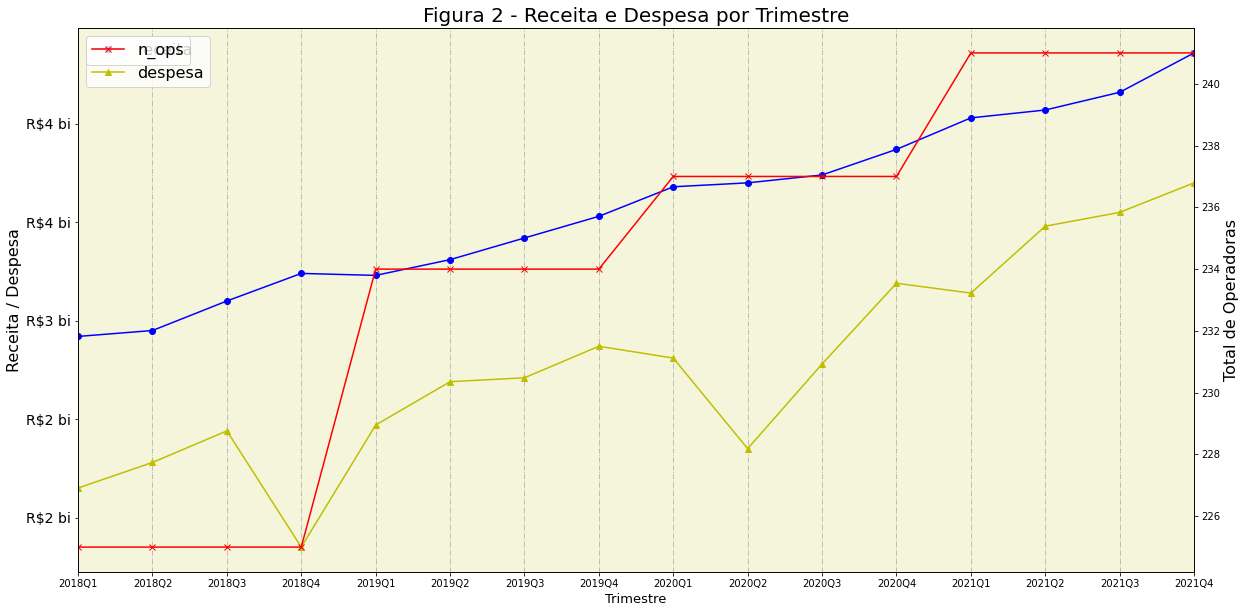

In [53]:
df_plot = ans_alterada25.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.savefig('ade_coopmed_01.png',
 bbox_inches="tight",
 pad_inches=1,
 facecolor='w')

plt.show()
del df_plot

### Merge com a base de beneficiarios

In [54]:
###############################################################################################################################################################################################
#                                                                              SIB -   BENEFICIARIOS
###############################################################################################################################################################################################

#Caminho da pasta com as bases de dados beneficiarios
path_beneficiario = r'D:\TCC\tcc-main\Beneficiarios\Beneficiarios_operadora_e_carteira.csv'

sib = pd.read_csv(path_beneficiario, sep=';', encoding='utf-8')

sib.columns = ['cd_operadora', 'razao_social', 'gr_modalidade', 'vigencia_plano', 'gr_contratacao', 'tipo_financiamento', 'mes', 'id_cmpt', 'nr_benef']

sib['mes']= pd.to_datetime(sib['mes'], format='%Y%m', errors='coerce').dropna()

sib.columns = ['cd_ops', 'razao_social', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'id_cmpt', 'benef']

sib.loc[(sib.contratacao == 'Coletivo empresarial'),'contratacao'] = 'Empresarial'
sib.loc[(sib.contratacao == 'Coletivo por adesão'),'contratacao'] = 'Adesao'
sib.loc[(sib.contratacao == 'Individual ou familiar'),'contratacao'] = 'Individual'

sib = sib.loc[(sib['id_calendar'] >= Periodo[0]) & (sib['id_calendar'] <= Periodo[1]), ['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'benef']]

sib['ano'] = sib['id_calendar'].dt.year

sib['trimestre'] = sib['id_calendar'].dt.to_period('Q')

sib = sib[['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre', 'benef']]

sib.sort_values(by=['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre'], inplace=True)

sib

,cd_ops,modalidade,vigencia,contratacao,financiamento,id_calendar,ano,trimestre,benef
146900,27,Médico-hospitalar,A,Individual,Não identificado,2017-09-01,2017,2017Q3,4
228965,27,Médico-hospitalar,A,Individual,Não identificado,2017-10-01,2017,2017Q4,4
332456,27,Médico-hospitalar,A,Individual,Não identificado,2017-11-01,2017,2017Q4,4
332180,27,Médico-hospitalar,A,Individual,Não identificado,2017-12-01,2017,2017Q4,4
33924,27,Médico-hospitalar,A,Individual,Não identificado,2018-01-01,2018,2018Q1,4
...,...,...,...,...,...,...,...,...,...
390516,422975,Odontológico,P,Adesao,Pre-estabelecido,2022-03-01,2022,2022Q1,137
137641,422975,Odontológico,P,Empresarial,Pre-estabelecido,2022-01-01,2022,2022Q1,92
250037,422975,Odontológico,P,Empresarial,Pre-estabelecido,2022-02-01,2022,2022Q1,99
29707,422975,Odontológico,P,Empresarial,Pre-estabelecido,2022-03-01,2022,2022Q1,115


In [55]:
# Segmenta porte da operadora pela quantidade de beneficiários médico-hospitalares

ops = sib.loc[(sib['id_calendar'] == Periodo[1]), ['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre', 'benef']]

ops = ops.groupby(['cd_ops'], as_index=False)['benef'].agg('sum')

ops.loc[(ops.benef > 100000),'port_ops'] = 'Grande'
ops.loc[((ops.benef <= 100000) & (ops.benef >= 20000)  ),'port_ops'] = 'Médio'
ops.loc[(ops.benef < 20000),'port_ops'] = 'Pequeno'

ops.head()

,cd_ops,benef,port_ops
0,477,115244,Grande
1,515,33402,Médio
2,582,990798,Grande
3,701,614431,Grande
4,884,8336,Pequeno


In [56]:
filtro1 = sib['modalidade'].isin(['Médico-hospitalar'])
filtro2 = sib['financiamento'] != 'Não identificado'
filtro3 = sib['contratacao'].isin(['Empresarial', 'Individual', 'Adesao'])

sib_filtrada = sib.loc[filtro1 & filtro2 & filtro3]

sib_filtrada = sib_filtrada.groupby(['ano','cd_ops','vigencia','contratacao', 'financiamento', 'id_calendar', 'trimestre'], as_index=False)['benef'].agg('sum')

sib_filtrada.replace('Pós-estabelecido','Pos-estabelecido', inplace=True)

sib_filtrada

,ano,cd_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,benef
0,2017,27,P,Adesao,Pre-estabelecido,2017-09-01,2017Q3,11173
1,2017,27,P,Adesao,Pre-estabelecido,2017-10-01,2017Q4,10909
2,2017,27,P,Adesao,Pre-estabelecido,2017-11-01,2017Q4,10754
3,2017,27,P,Adesao,Pre-estabelecido,2017-12-01,2017Q4,10584
4,2017,27,P,Empresarial,Pre-estabelecido,2017-09-01,2017Q3,17237
...,...,...,...,...,...,...,...,...
106444,2022,422827,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,188
106445,2022,422835,P,Empresarial,Pre-estabelecido,2022-01-01,2022Q1,3
106446,2022,422835,P,Empresarial,Pre-estabelecido,2022-02-01,2022Q1,7
106447,2022,422835,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,14


In [57]:
#################################################################################################################################################################################
#Calcula média de beneficiários acumulada no ano por operadora e tipo de contratação:

sib_filtrada = sib_filtrada.sort_values(['ano','cd_ops','contratacao','id_calendar','trimestre','benef'], ascending=[True, True, True, True, True, False])

sib_filtrada['mes'] = sib_filtrada['id_calendar'].dt.month 

sib_filtrada['benefm'] = (sib_filtrada.groupby(['cd_ops','contratacao', 'ano', 'trimestre'], sort=False)['benef'].apply(lambda x: x.expanding().mean()))

sib_filtrada['n_meses'] = (sib_filtrada.groupby(['cd_ops','contratacao', 'ano', 'trimestre'], sort=False)['benef'].transform('size'))

sib_filtrada = sib_filtrada[['ano','cd_ops','vigencia','contratacao','financiamento','id_calendar','trimestre','benef', 'benefm', 'n_meses', 'mes']]

sib_filtrada

,ano,cd_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,benef,benefm,n_meses,mes
0,2017,27,P,Adesao,Pre-estabelecido,2017-09-01,2017Q3,11173,11173.00000,1,9
1,2017,27,P,Adesao,Pre-estabelecido,2017-10-01,2017Q4,10909,10909.00000,3,10
2,2017,27,P,Adesao,Pre-estabelecido,2017-11-01,2017Q4,10754,10831.50000,3,11
3,2017,27,P,Adesao,Pre-estabelecido,2017-12-01,2017Q4,10584,10749.00000,3,12
4,2017,27,P,Empresarial,Pre-estabelecido,2017-09-01,2017Q3,17237,17237.00000,1,9
...,...,...,...,...,...,...,...,...,...,...,...
106444,2022,422827,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,188,143.00000,2,3
106445,2022,422835,P,Empresarial,Pre-estabelecido,2022-01-01,2022Q1,3,3.00000,4,1
106446,2022,422835,P,Empresarial,Pre-estabelecido,2022-02-01,2022Q1,7,5.00000,4,2
106448,2022,422835,P,Empresarial,Pos-estabelecido,2022-03-01,2022Q1,646,218.66667,4,3


In [58]:
sib_filtrada = sib_filtrada.loc[sib_filtrada['mes'].isin([3,6,9,12])]

sib_filtrada.drop(['mes','benefm','n_meses'], axis='columns', inplace=True)

sib_filtrada = sib_filtrada[['ano','cd_ops','vigencia','contratacao','financiamento','id_calendar','trimestre','benef']]

sib_filtrada['ano'] =  pd.to_datetime(sib_filtrada['ano'], format='%Y')

sib_filtrada['ano'] = sib_filtrada['ano'].dt.to_period('Y')

sib_filtrada['cd_ops'] = sib_filtrada['cd_ops'].astype('str')

sib_filtrada = sib_filtrada[(sib_filtrada['contratacao'] == tipo_contratacao)].reset_index(drop=True)

sib_filtrada = sib_filtrada[['ano','cd_ops','trimestre','benef']]

sib_filtrada = sib_filtrada.groupby(['ano','cd_ops','trimestre'],as_index=False).agg({'benef':'sum'})

sib_filtrada


,ano,cd_ops,trimestre,benef
0,2017,27,2017Q3,11173
1,2017,27,2017Q4,10584
2,2017,300012,2017Q3,747
3,2017,300012,2017Q4,719
4,2017,300713,2017Q3,3410
...,...,...,...,...
10227,2022,422771,2022Q1,462
10228,2022,422827,2022Q1,33
10229,2022,5711,2022Q1,116492
10230,2022,6246,2022Q1,228443


In [59]:
#Criação do dataframe final para ser utilizados na predição dos forecasts
ans_alterada25 = pd.merge(ans_alterada24,sib_filtrada, how='left', on=['ano','cd_ops','trimestre'])

ans_alterada25 = ans_alterada25[['ano','cd_ops','trimestre','receita','despesa','benef']]

ans_alterada25['modalidade'] = tipo_modalidade

ans_alterada25['contratacao'] = tipo_contratacao

ans_alterada25.to_csv('ade_coopmed.csv', sep=';', index=False, encoding='mbcs', decimal=',')

ans_alterada25 = ans_alterada25[['ano','cd_ops','trimestre','receita','despesa','benef']]

ans_alterada25.head()

,ano,cd_ops,trimestre,receita,despesa,benef
0,2018,300713,2018Q1,2362654.19351,1601555.77960,3419.00000
1,2018,353663,2018Q2,276093.64255,116488.62647,8547.00000
2,2018,353663,2018Q3,300628.24372,153440.36055,8544.00000
3,2018,353663,2018Q4,309400.85020,130789.88242,8660.00000
4,2018,353698,2018Q1,1384196.35248,1226777.92848,259.00000


In [60]:
ans_alterada26 = ans_alterada25.groupby(['ano','trimestre'], as_index=False).agg({  'receita':lambda x: sum_billion(x),
                                                                                    'despesa':lambda x: sum_billion(x),
                                                                                    'benef': 'sum',
                                                                                    'cd_ops':lambda x: x.nunique()})

ans_alterada26['pct_despesa'] = ans_alterada26.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_alterada26.columns = ['ano','trimestre','receita','despesa','benef','n_ops','pct_despesa']

ans_alterada26 = ans_alterada26[['trimestre','receita','despesa','benef','n_ops','pct_despesa']]

ans_alterada26.to_csv('ade_coopmed_resumo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

ans_alterada26.set_index('trimestre', inplace=True)

display(ans_alterada26.info()) 
display(ans_alterada26) 

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 16 entries, 2018Q1 to 2021Q4
Freq: Q-DEC
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   receita      16 non-null     float64
 1   despesa      16 non-null     float64
 2   benef        16 non-null     float64
 3   n_ops        16 non-null     int64  
 4   pct_despesa  16 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 768.0 bytes


None

,receita,despesa,benef,n_ops,pct_despesa
trimestre,,,,,
2018Q1,2.92000,2.15000,2425386.00000,225,73.63000
2018Q2,2.95000,2.28000,2448775.00000,225,77.29000
2018Q3,3.10000,2.44000,2463167.00000,225,78.71000
2018Q4,3.24000,1.85000,2471017.00000,225,57.10000
2019Q1,3.23000,2.47000,2527436.00000,234,76.47000
2019Q2,3.31000,2.69000,2559347.00000,234,81.27000
2019Q3,3.42000,2.71000,2567281.00000,234,79.24000
2019Q4,3.53000,2.87000,2588440.00000,234,81.30000
2020Q1,3.68000,2.81000,2706972.00000,237,76.36000


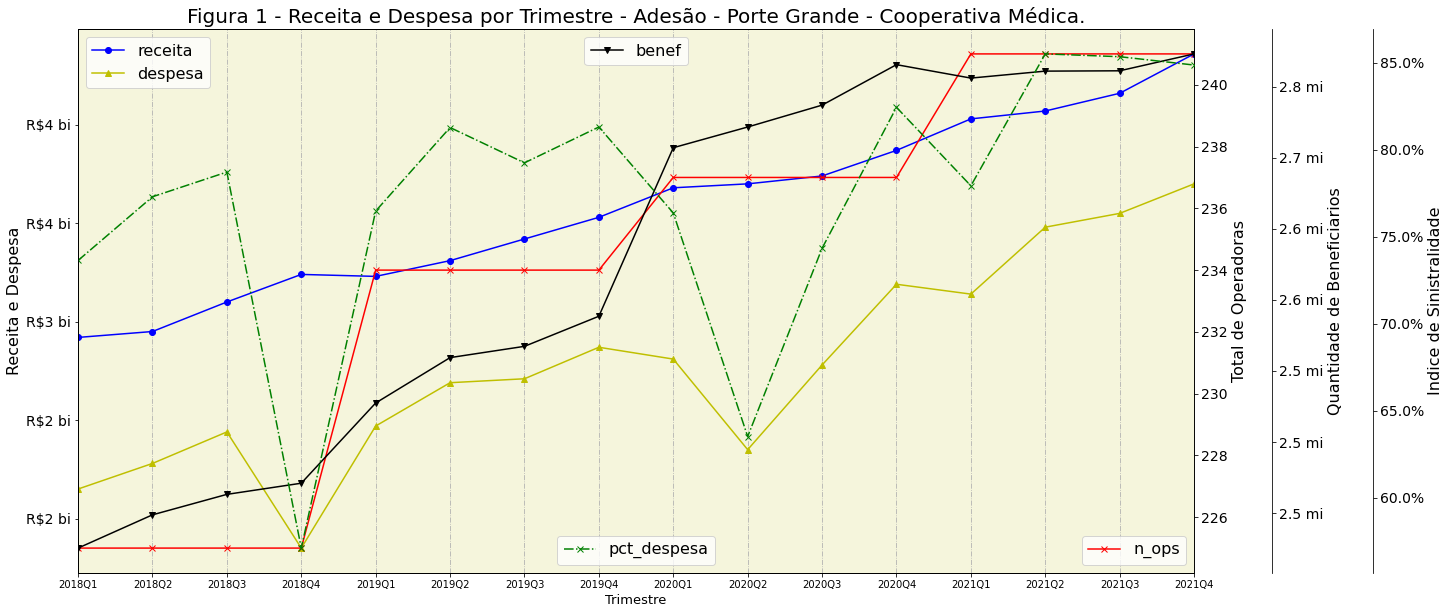

In [61]:
df_plot = ans_alterada26.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 1 - Receita e Despesa por Trimestre - Adesão - Porte Grande - Cooperativa Médica.',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(yticks.astype(int), fontsize = 14)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'lower right', fontsize = 16)

ax3 = ax1.twinx()

ax3.spines.right.set_position(("axes", 1.07))

df_plot.plot(y=['benef'], figsize=(20,10), style=['kv-'], ax=ax3)
ax3.set_xticks(df_plot.index)
ax3.set_xticklabels(df_plot.index)
ax3.set_xlabel('Trimestre', fontsize = 13)
yticks = ax3.get_yticks()
ax3.set_yticklabels(['{:.1f} mi'.format(x/1e6) for x in yticks], fontsize = 14)
ax3.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax3.legend(loc = 'upper center', fontsize = 16)

ax4 = ax1.twinx()

ax4.spines.right.set_position(("axes", 1.16))

df_plot.plot(y=['pct_despesa'], figsize=(20,10), style=['gx-.'], ax=ax4)
ax4.set_xticks(df_plot.index)
ax4.set_xticklabels(df_plot.index)
ax4.set_xlabel('Trimestre', fontsize = 13)
yticks = ax4.get_yticks()
ax4.set_yticklabels(['{:.1f}%'.format(x) for x in yticks], fontsize = 14)
ax4.set_ylabel('Indice de Sinistralidade', fontsize=16)
ax4.legend(loc = 'lower center', fontsize = 16)

plt.savefig('ade_coopmed_02.png',
 bbox_inches="tight",
 pad_inches=1,
 facecolor='w')

plt.show()

del df_plot

In [62]:
#Cria o rankin das operadoras com maior receita e despesa
ans_alterada27 = ans_alterada25.groupby(['ano','cd_ops'], as_index=False).agg({ 'receita':lambda x: sum_million(x),
                                                                                'despesa':lambda x: sum_million(x)})

ans_alterada27.sort_values(by=['ano','receita'], ascending=[True,False], inplace=True)

ans_alterada27.head()

,ano,cd_ops,receita,despesa
221,2018,393321,1801.06000,997.92000
61,2018,319996,1366.48000,871.97000
124,2018,343889,1101.39000,678.26000
54,2018,317144,423.86000,281.22000
177,2018,357391,394.20000,252.09000


In [63]:
ans_alterada_ops = ans_alterada27.head(100)

ans_alterada_ops = ans_alterada_ops[['cd_ops']].reset_index(drop=True)

keys = list(ans_alterada_ops.columns.values)
i1 = ans_alterada25.set_index(keys).index
i2 = ans_alterada_ops.set_index(keys).index

ans_alterada28 =  ans_alterada25[i1.isin(i2)]

ans_alterada28.sort_values(by=['receita'], ascending=False, inplace=True)

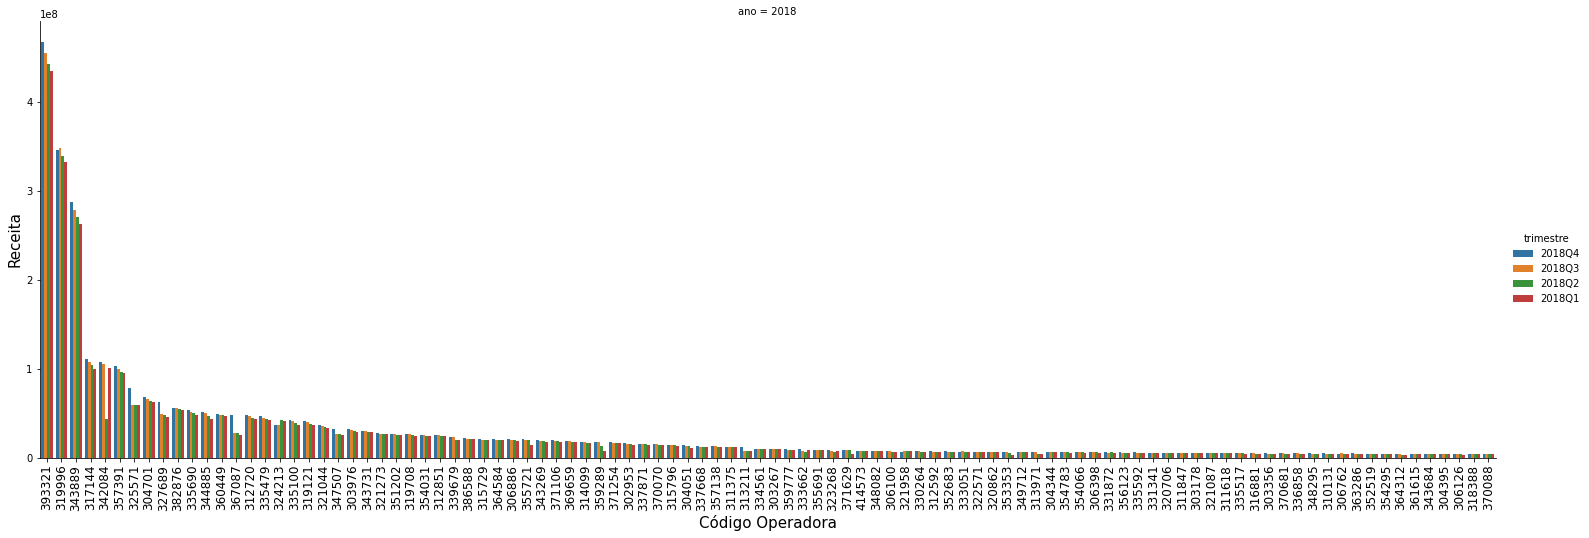

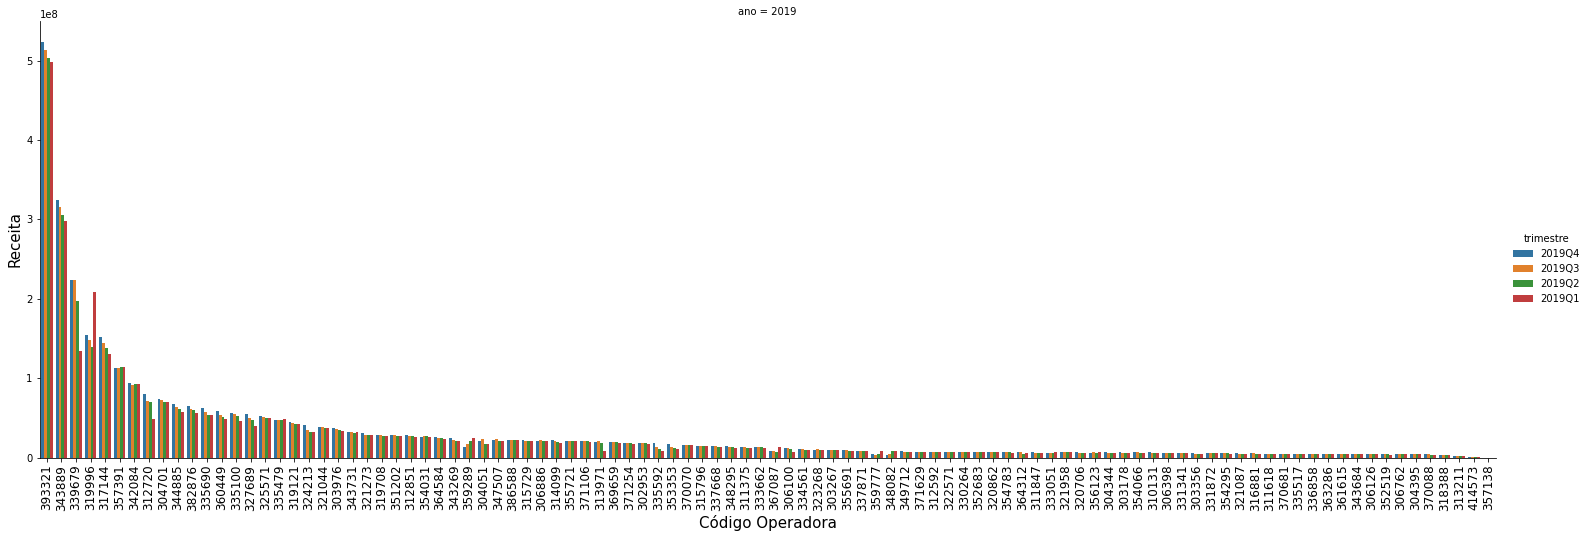

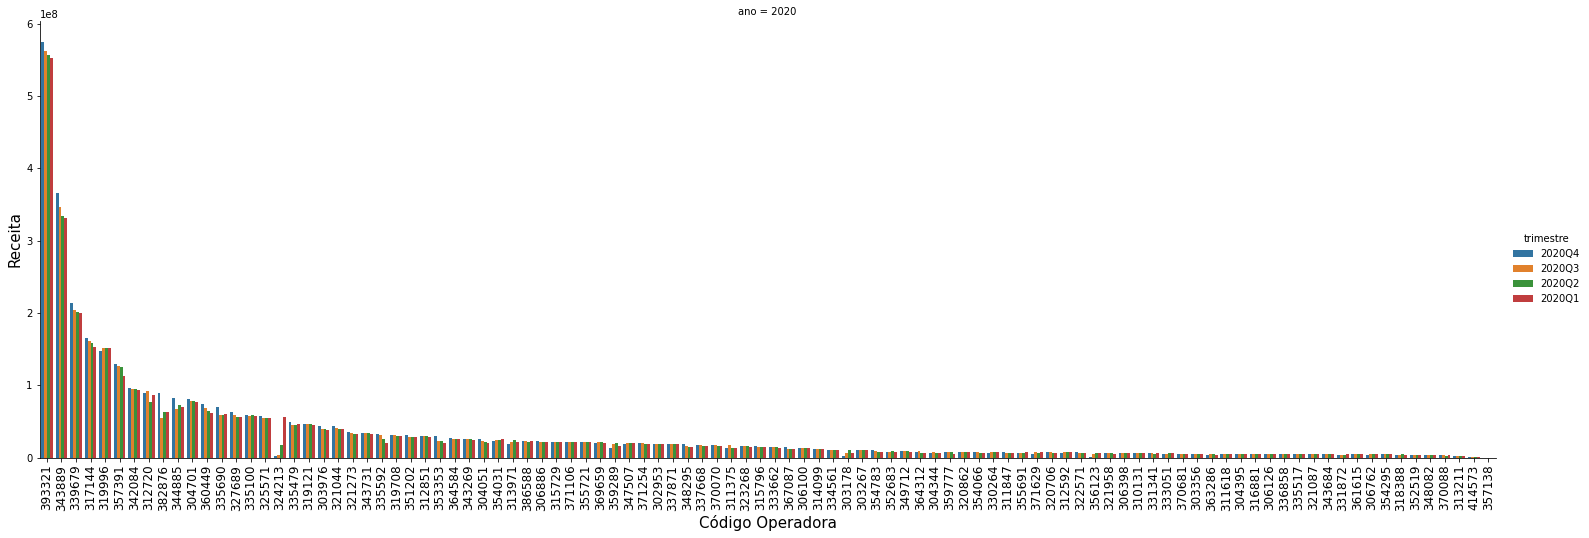

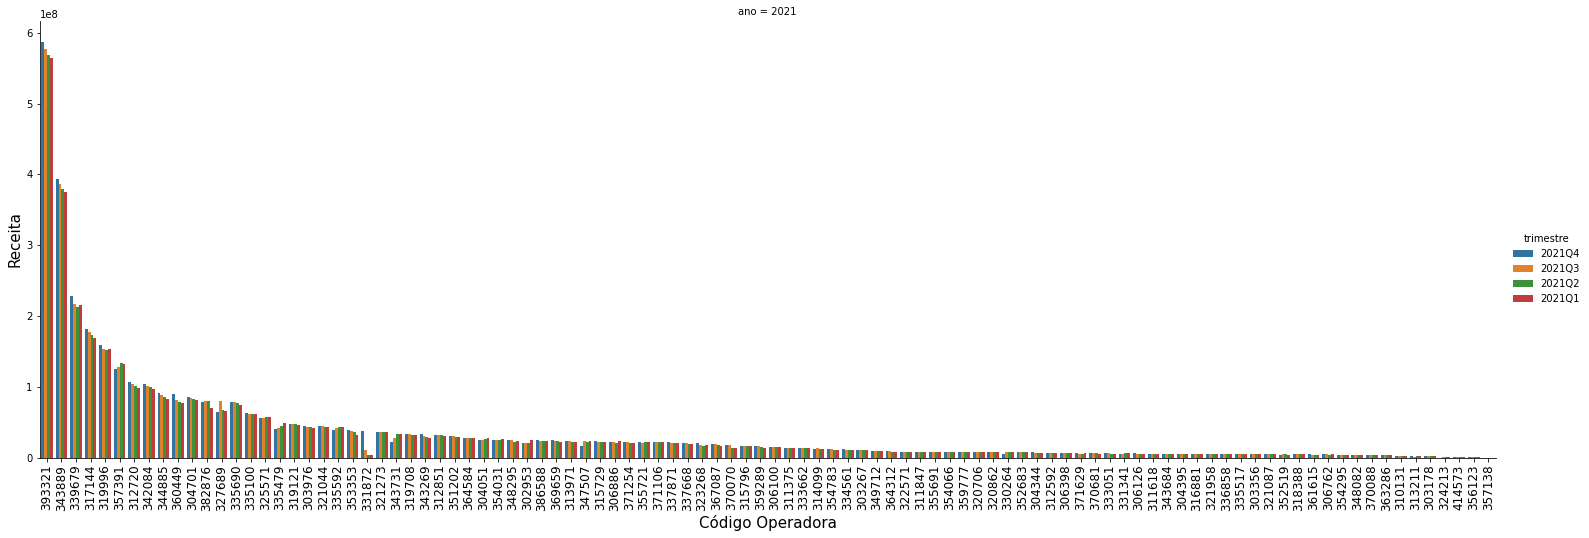

In [64]:
df_plot = ans_alterada28.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

del df_plot

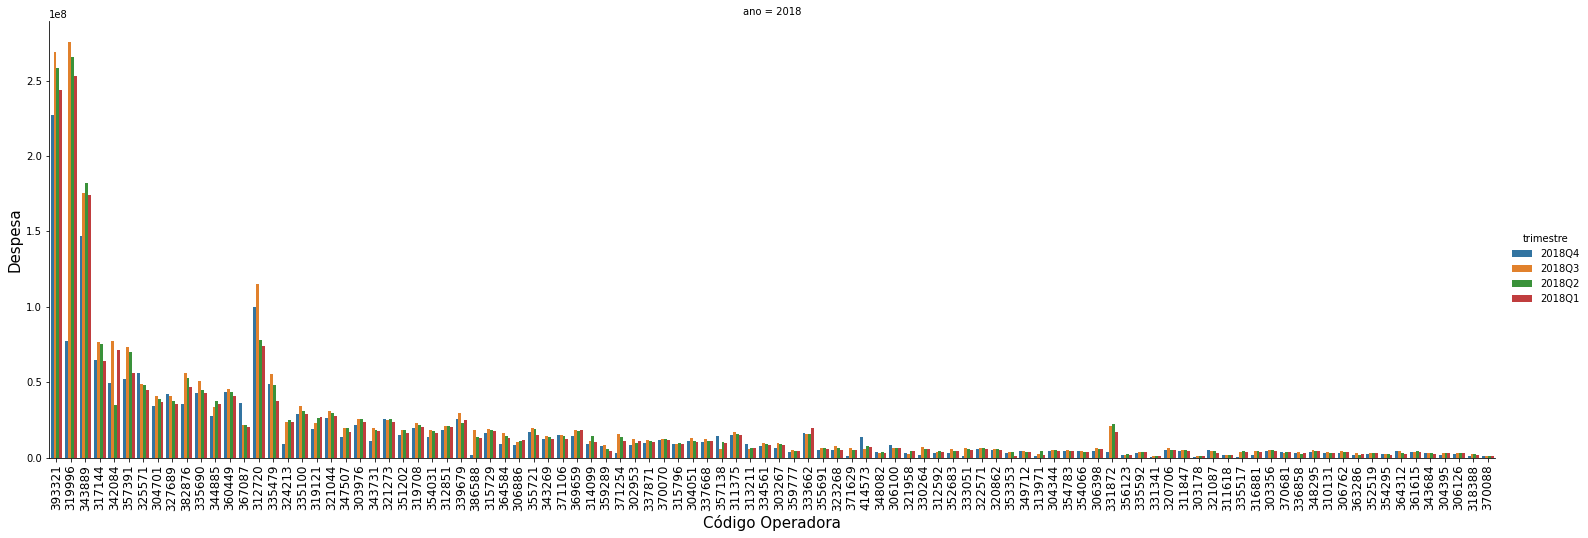

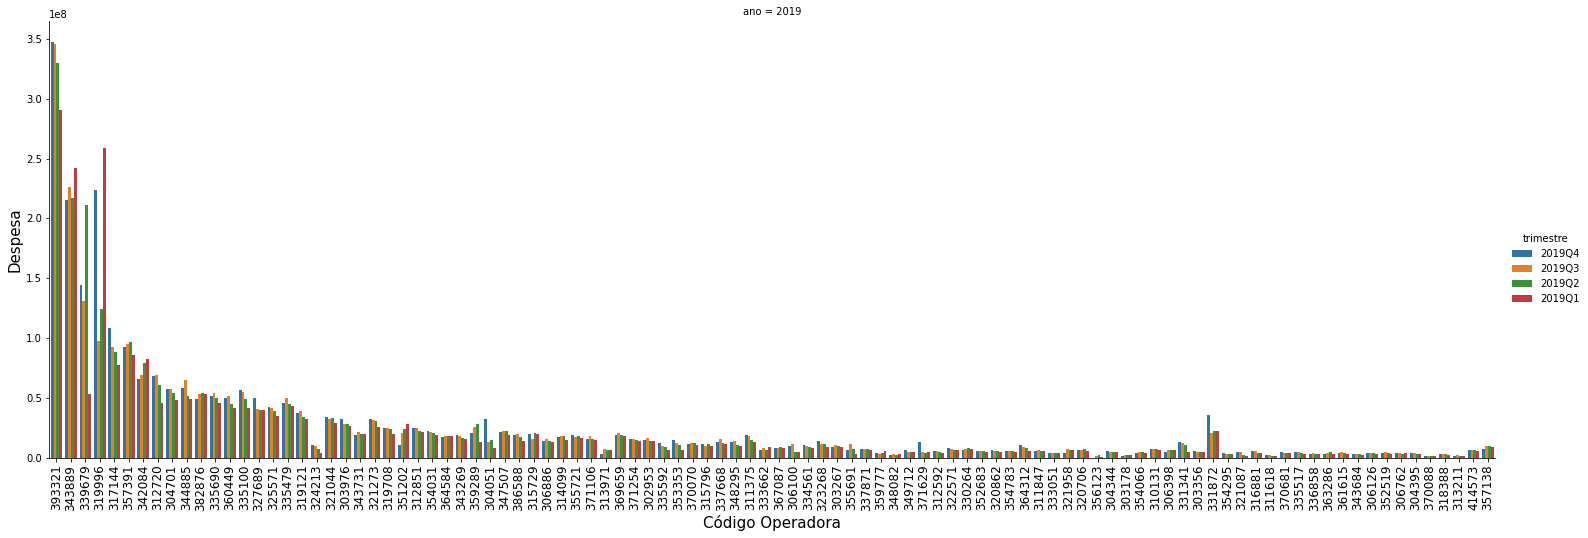

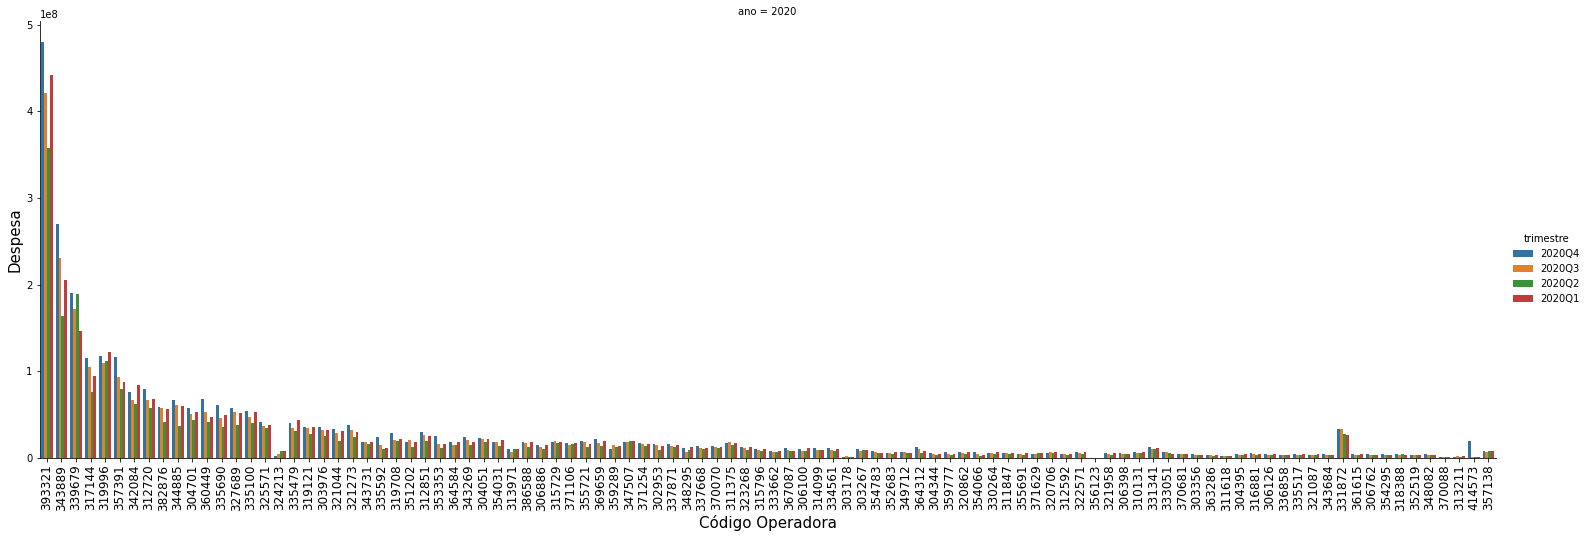

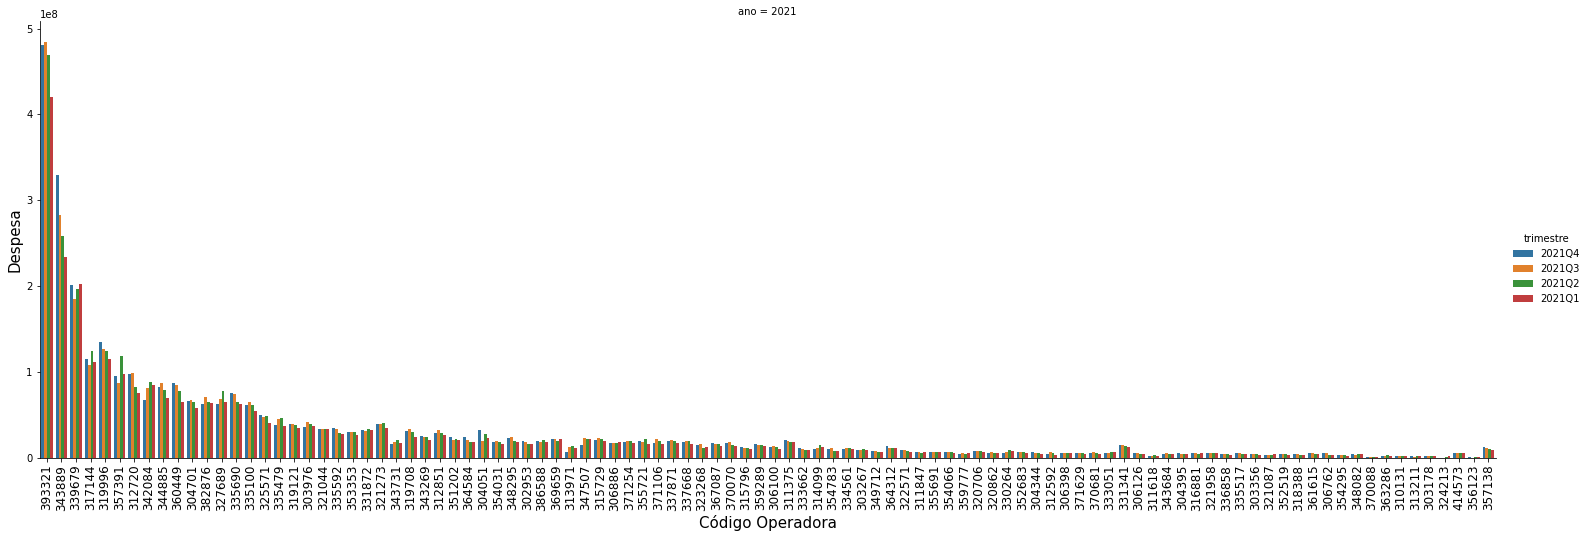

In [65]:
df_plot = ans_alterada28.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

del df_plot